# Modeling FastText Notebook (Joulin et al. 2016)

**Based on the developed pipeline in `template_logreg_tfidf.ipynb`**

We use FastText in this Notebook as an end-to-end classifier. Read Joulin et al. 2016 "Bag of Tricks for Efficient Text Classification" for more information

In [3]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import torch

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    ParameterGrid
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import (
    fbeta_score,
    make_scorer
)
from joblib import dump, load
from scipy.stats import loguniform, randint

root_path = Path.cwd().parents[1]  #go to root
sys.path.append(str(root_path))
from src.evaluation_visualization import (
    plot_learning_curves,
    plot_confusion_matrix,
    plot_roc_and_pr_curves,
    plot_threshold_curves,
    extended_classification_report,
    get_metrics_dict,
    quick_f2_score_default_threshold
)

from src.fasttext_sklearn import FastTextSklearnClassifier #our FastText Classifier
from src.preprocessing import process_file
from src.optimize_threshold import (
    optimize_threshold_with_cv,
    get_threshold_evaluation_data,
    get_threshold_evaluation_data_cv
)
from src.optuna_optimizer import (
    optimize_with_optuna_tpe,
    sample_class_weight_value,
    grid_search_with_optuna
)
from src.optuna_visualizations import (
    plot_optuna_study_analysis,
    quick_optuna_analysis
)

from src.phrase_transformer import PhraseDetector

c:\Users\tdoro\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**a) FastTextClassifier with basic preprocessed data**

In [4]:
# Load and preprocess data (basic mode)
df_basiccleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='basic'  # basic cleaning mode
)

# Map labels to binary values
df_basiccleaned['Label'] = df_basiccleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

FastText TPE basic

Starting Optuna hyperparameter optimization ...


c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0) which is of type tuple.
  warnings.warn(message)
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 4) which is of type tuple.
  warnings.warn(message)
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\distributi

Best parameters found by Optuna TPE: {'clf__lr': 0.0022158645374549917, 'clf__dim': 200, 'clf__epoch': 10, 'clf__ws': 5, 'clf__wordNgrams': 3, 'clf__minCount': 1, 'subword_combo': (0, 0), 'clf__pos_oversample': 1.9903538202225404}
Best F2 score during optimization: 0.646

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


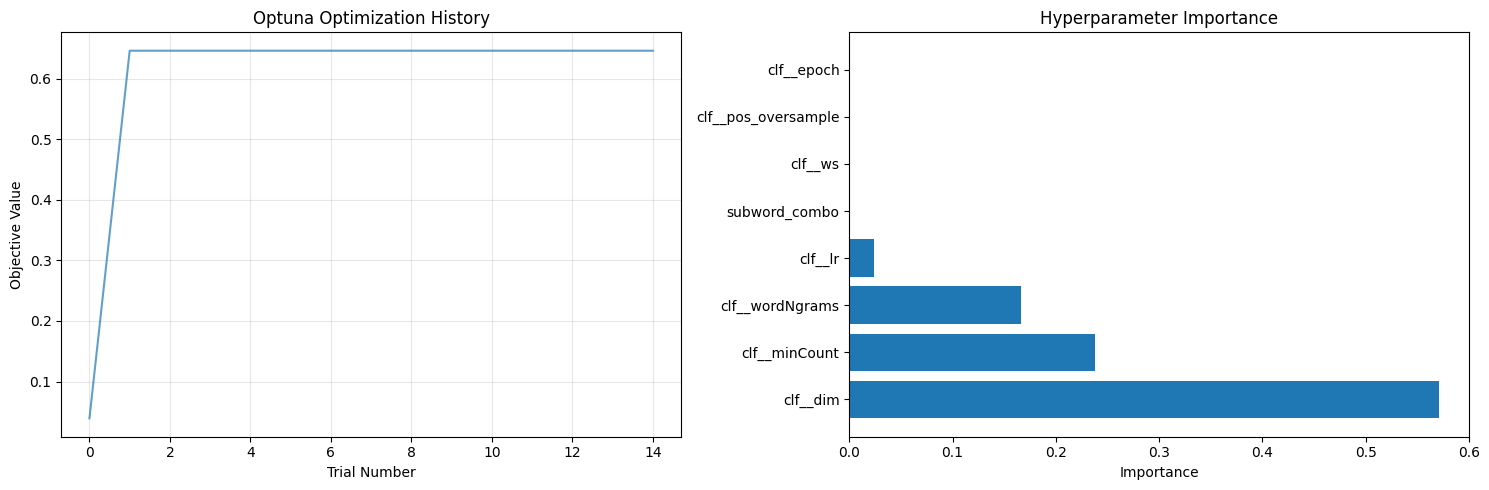


2. Parameter Value Distributions:


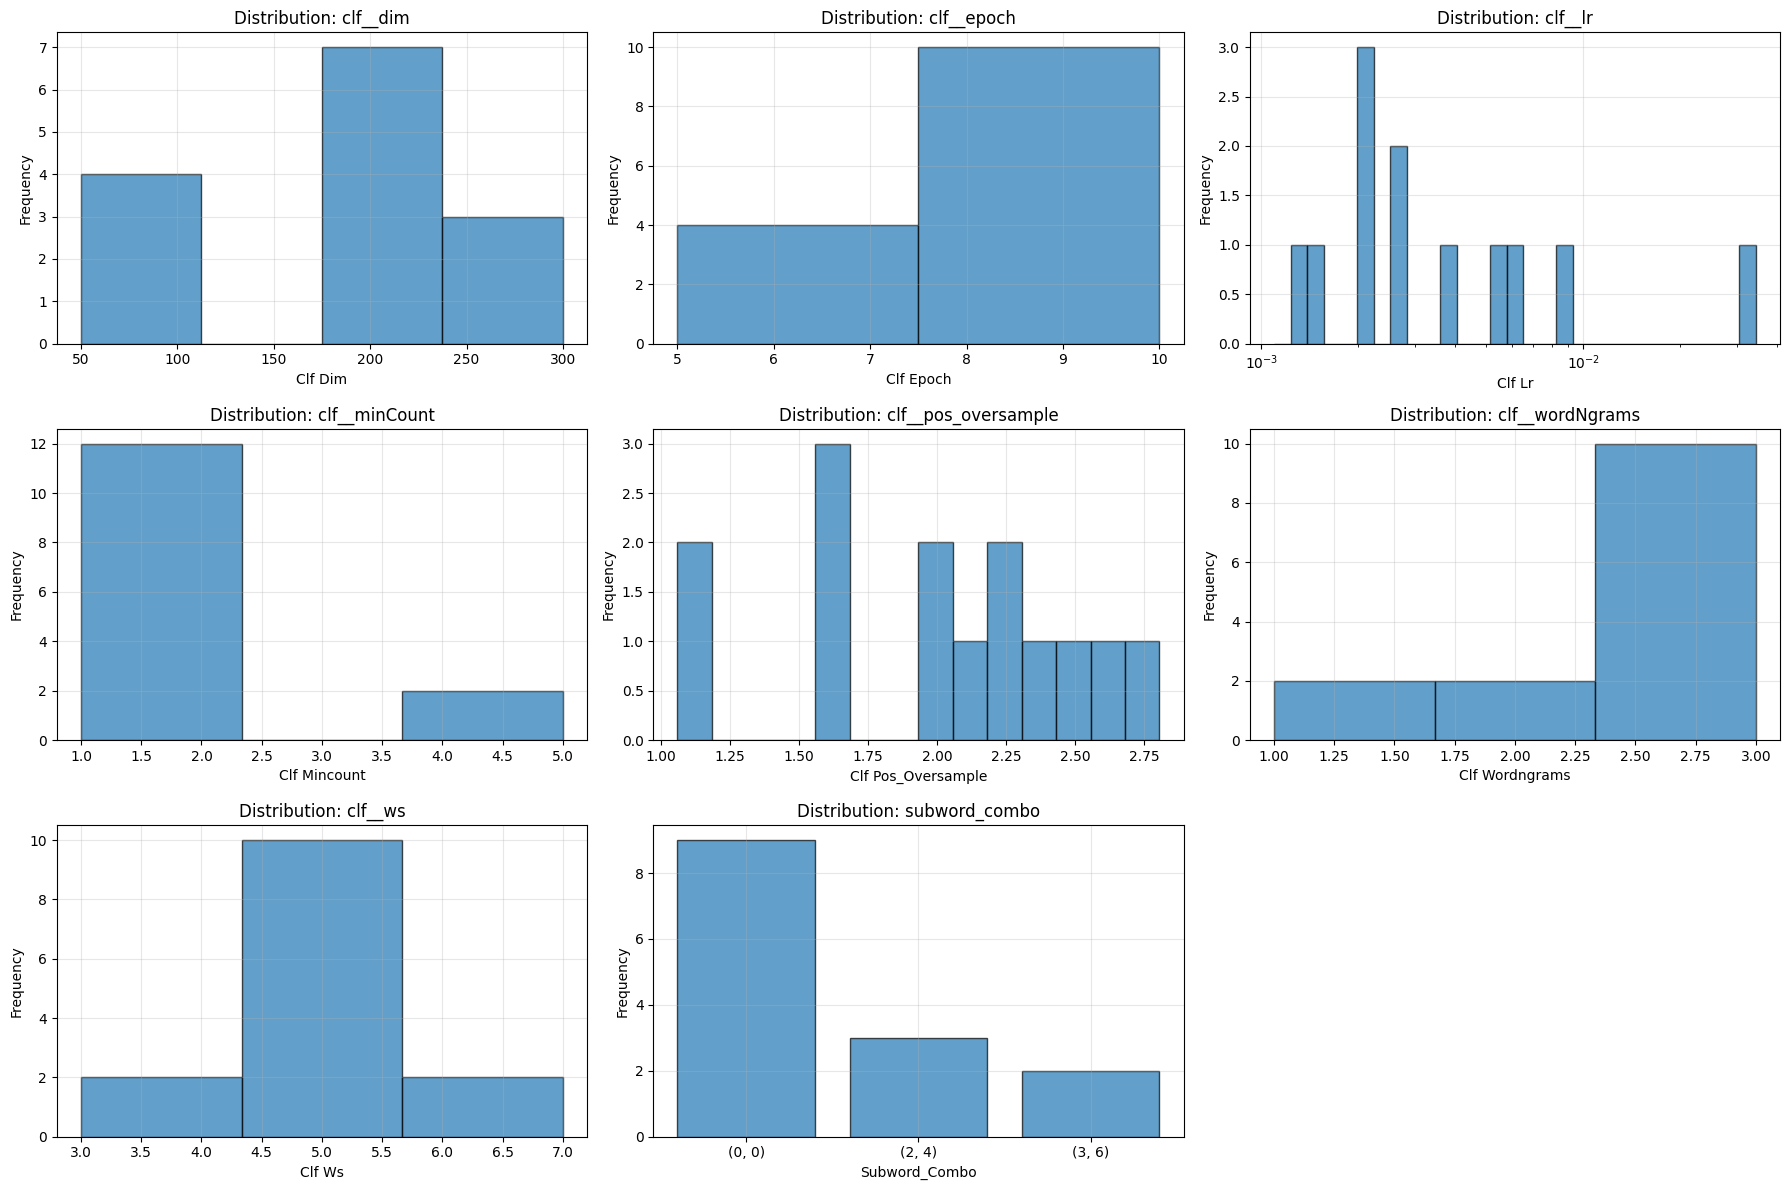


3. Performance vs Individual Parameters:


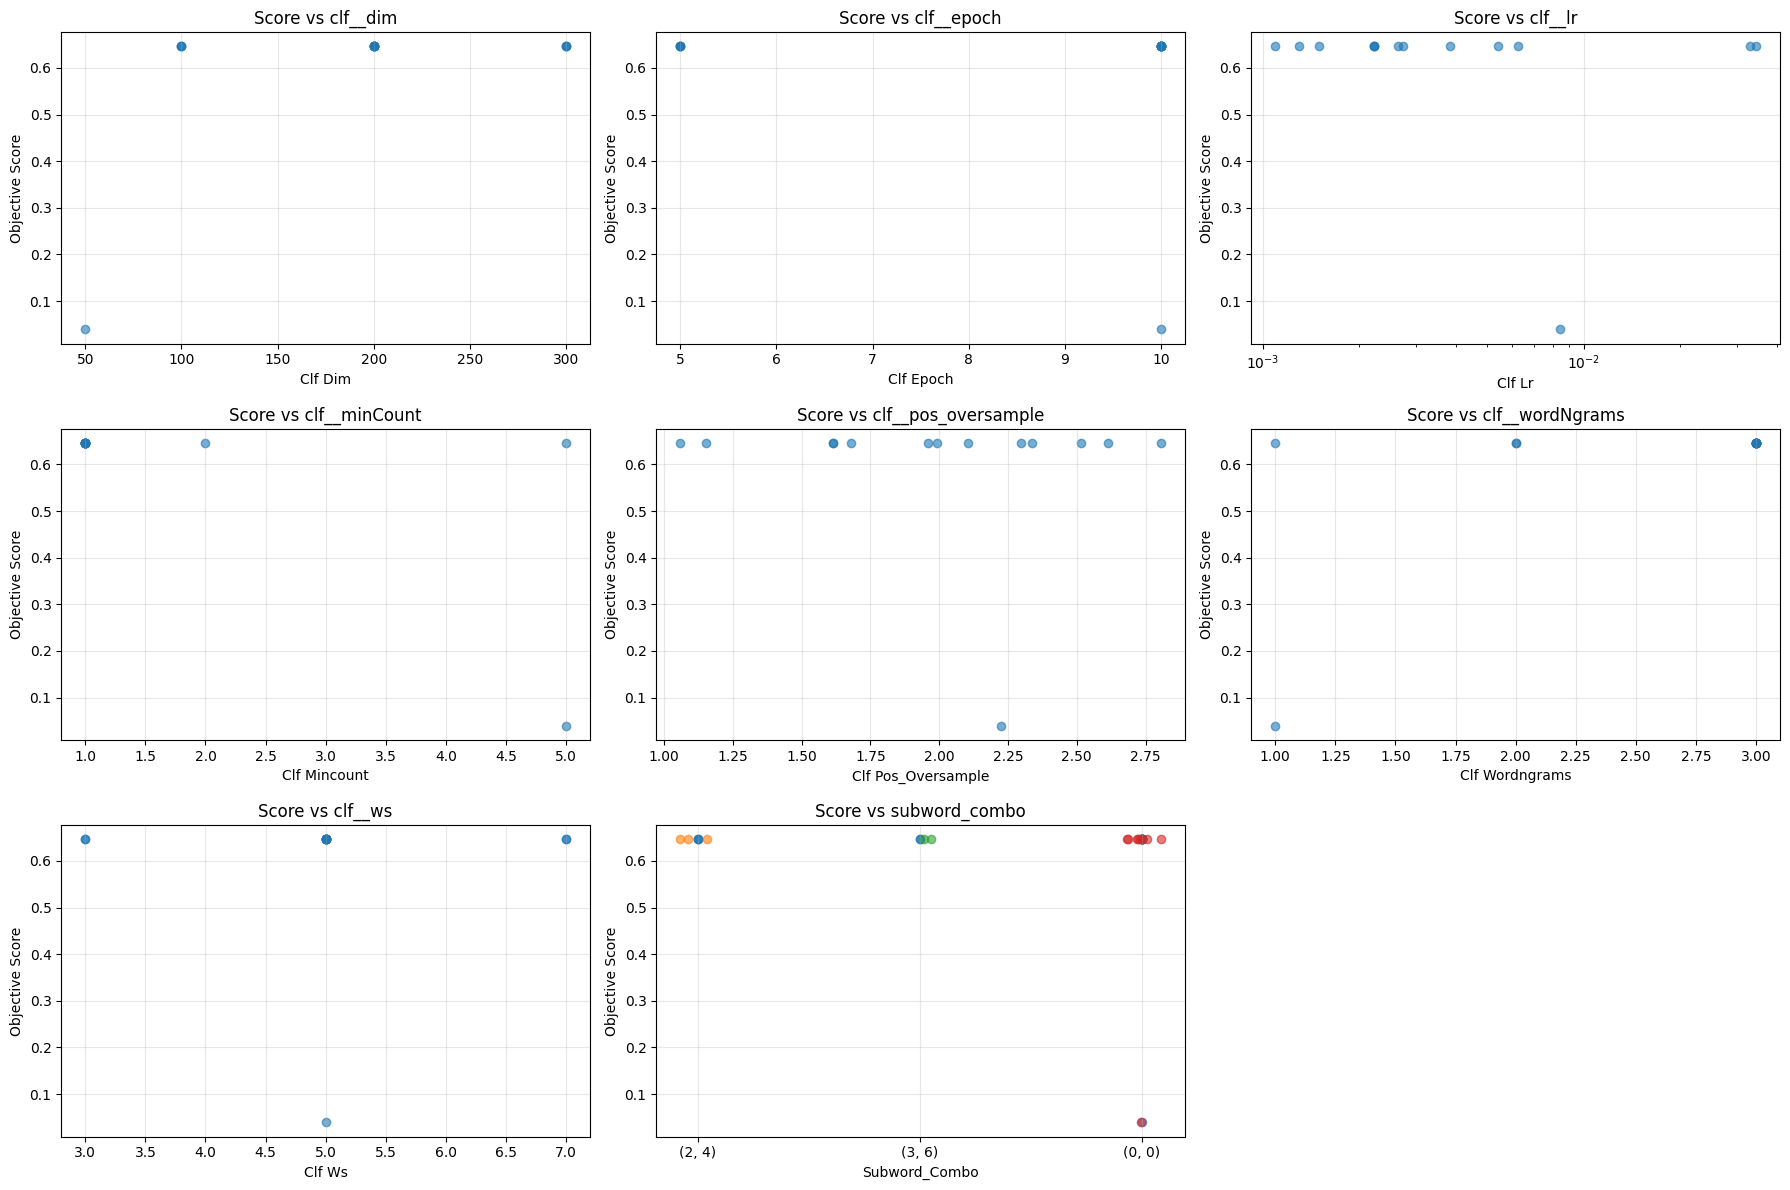


4. Convergence Analysis:


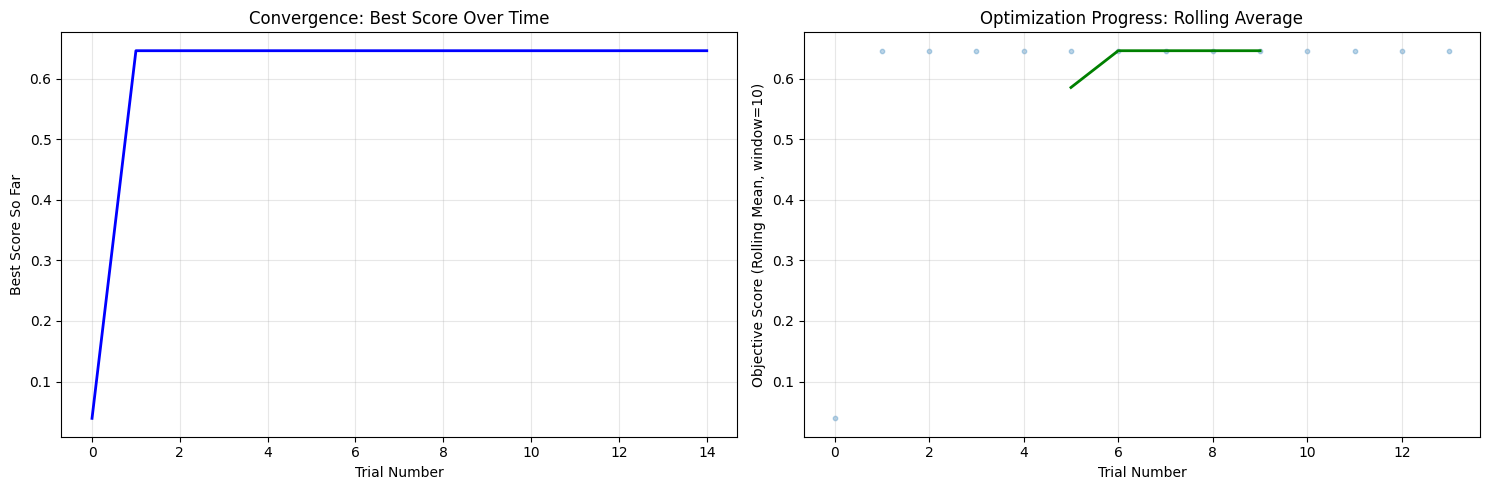


5. Trial Status Overview:


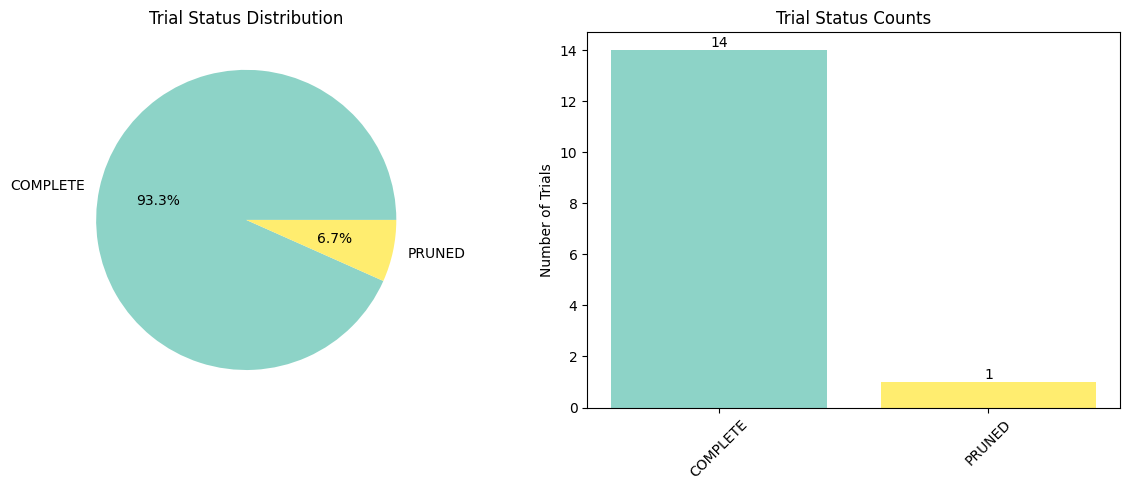


6. Top 10 Best Trials:
Rank Trial#  Score      dim          epoch        lr           minCount     pos_oversample wordNgrams   ws           subword_combo
----------------------------------------------------------------------------------------------------------------------------------
1    1       0.6461     200          10           0.0022       1            1.9904       3            5            (0, 0)      
2    2       0.6461     200          10           0.0062       1            1.6152       3            5            (0, 0)      
3    3       0.6461     200          10           0.0013       1            2.1033       3            3            (2, 4)      
4    4       0.6461     300          10           0.0011       1            1.0594       1            5            (0, 0)      
5    5       0.6461     100          10           0.0026       1            2.8058       3            5            (0, 0)      
6    6       0.6461     200          5            0.0038       1          

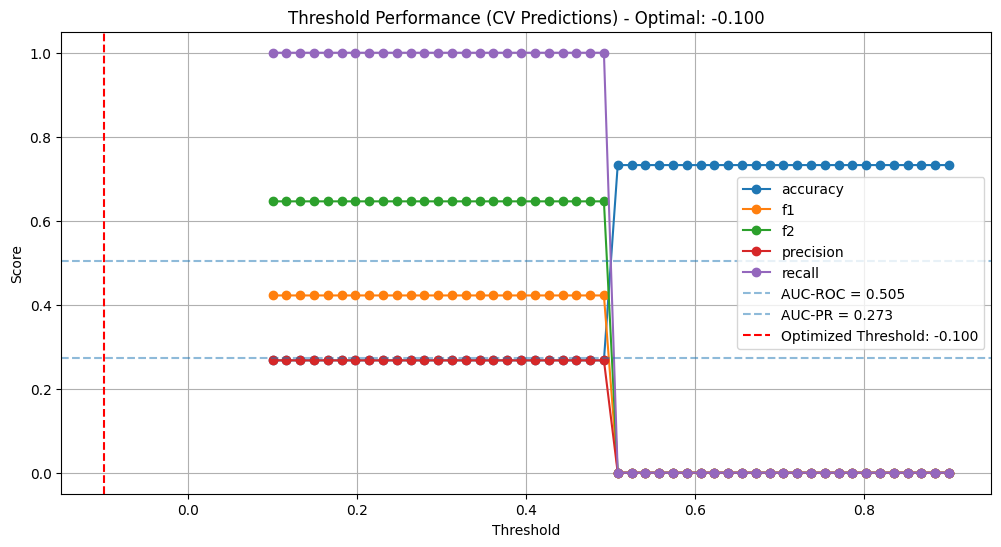

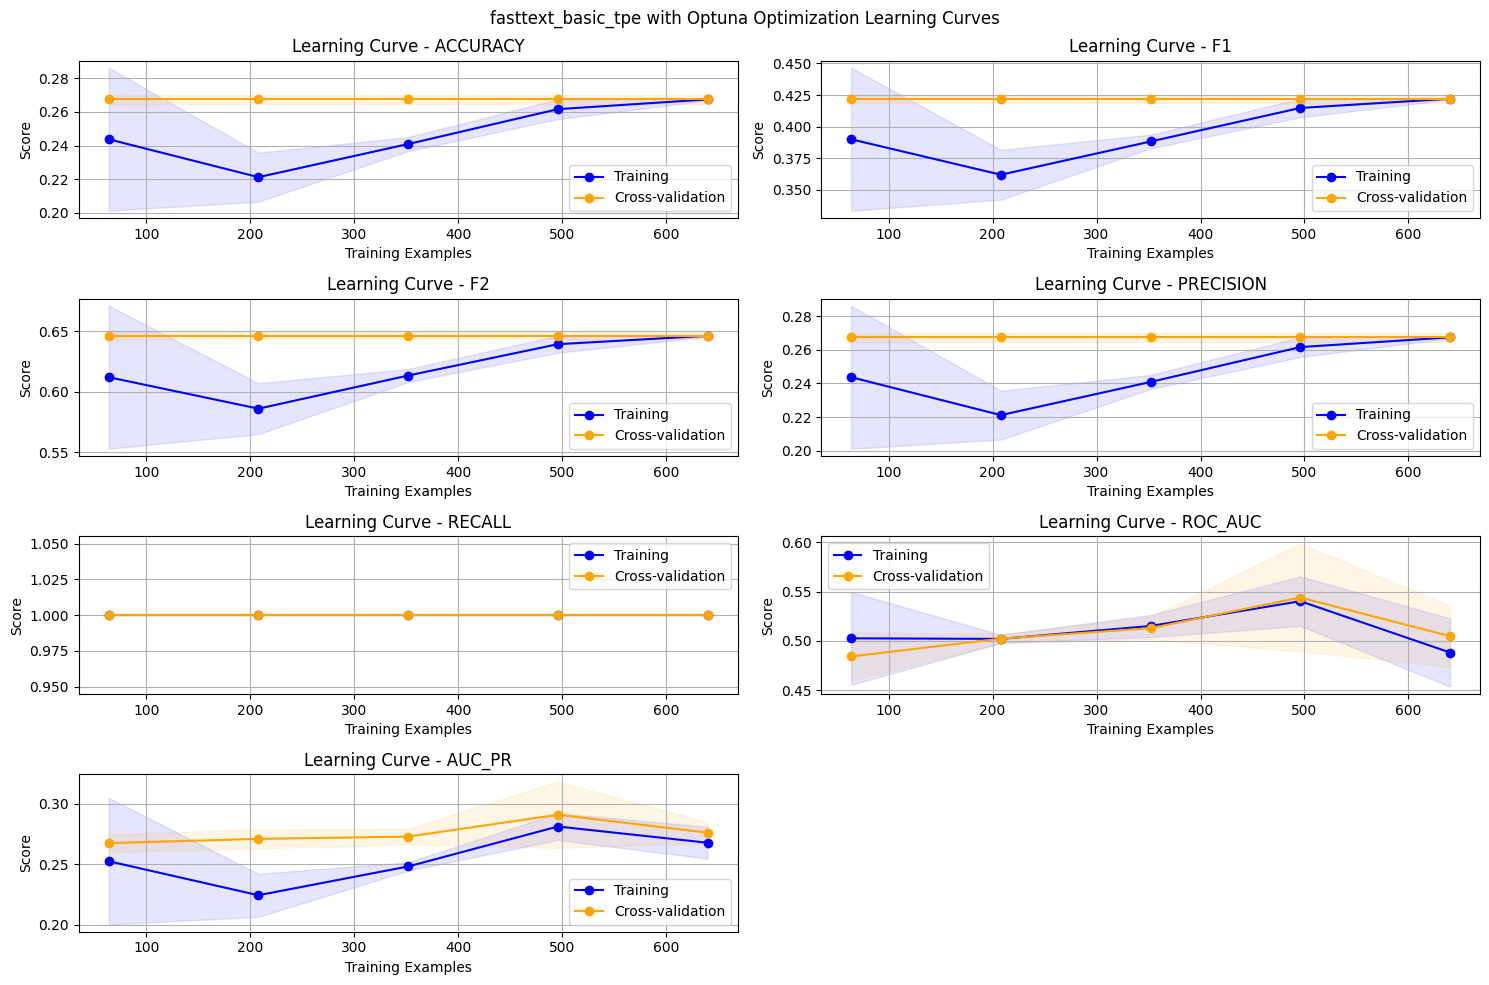


Final Threshold: -0.10
F2-score with default threshold (0.5): 0.649

Test Set Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       146
           1       0.27      1.00      0.43        54

    accuracy                           0.27       200
   macro avg       0.14      0.50      0.21       200
weighted avg       0.07      0.27      0.11       200

Additional Metrics:
Accuracy   0.270
F2-score   0.649
AUC-ROC    0.512
AUC-PR     0.275



c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


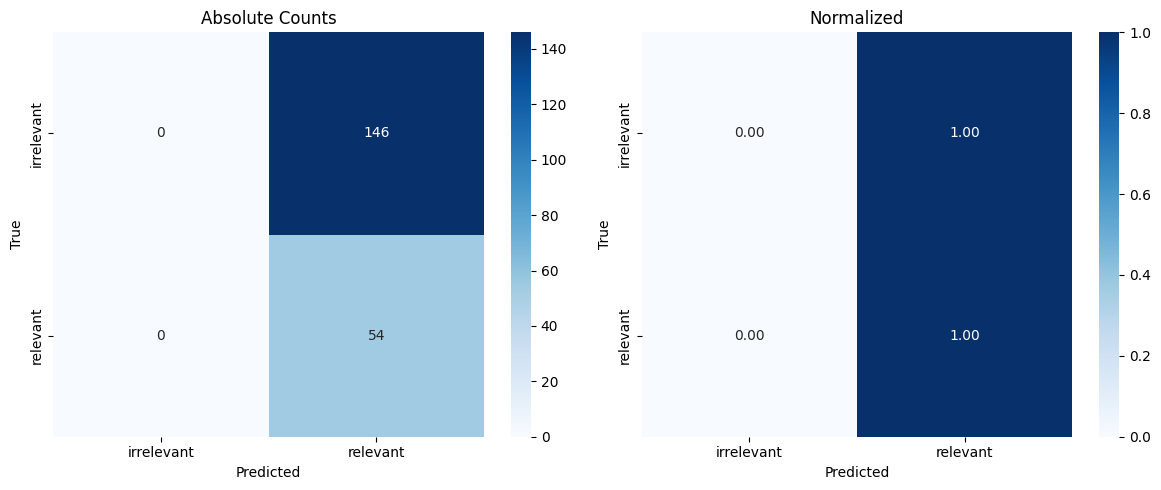

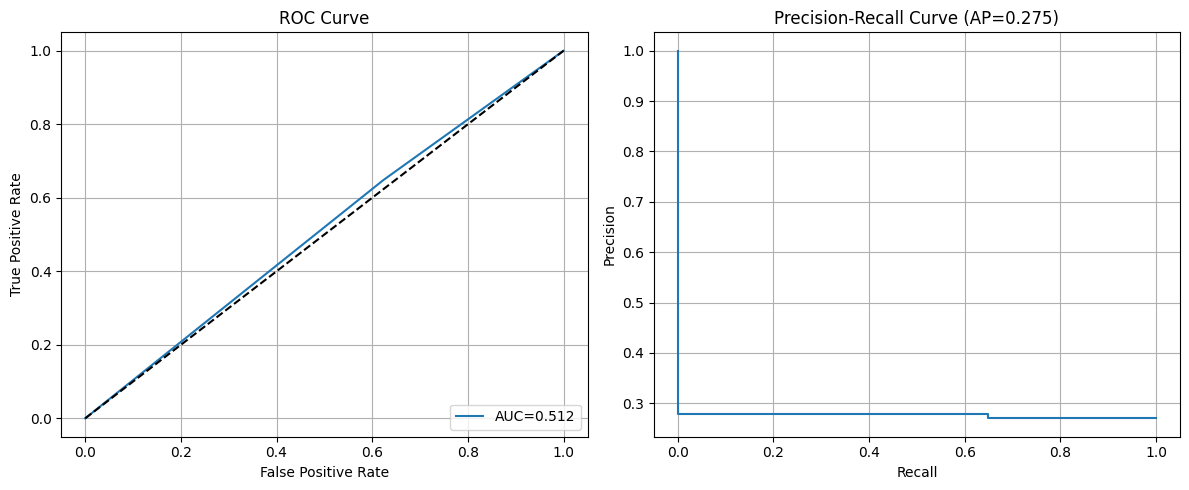

c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3


Model saved as model_fasttext_basic_tpe.joblib


In [ ]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

pipeline_fasttext = Pipeline([
    # no more steps, because we use fasttext as end-to-end model here
    ("clf", FastTextSklearnClassifier(
        lr=0.1, 
        dim=100, 
        epoch=10, 
        ws=5,
        wordNgrams=2, 
        minn=2, 
        maxn=4, 
        minCount=2,
        neg=10, 
        thread=1,  # reproducibility
        loss="softmax",
        bucket=1_000_000, 
    ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space 
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
param_space = {
    # (Joulin et al.: LR, Dim, n-grams, Subwords)
    "clf__lr":           (lambda t: t.suggest_float("clf__lr", 1e-3, 3e-1, log=True)),
    "clf__dim":          (lambda t: t.suggest_categorical("clf__dim", [50, 100, 150, 200, 300])),
    "clf__epoch":        (lambda t: t.suggest_categorical("clf__epoch", [5, 10])),  # cap 10
    "clf__ws":           (lambda t: t.suggest_categorical("clf__ws", [3, 5, 7])),
    "clf__wordNgrams":   (lambda t: t.suggest_categorical("clf__wordNgrams", [1, 2, 3])),
    "clf__minCount":     (lambda t: t.suggest_categorical("clf__minCount", [1, 2, 5])),

    # Subword-Combinations (minn/maxn coupled)
    "clf__minn": (lambda t: t.suggest_categorical("subword_combo", [(0,0), (2,4), (3,6)])[0]),
    "clf__maxn": (lambda t: t.suggest_categorical("subword_combo", [(0,0), (2,4), (3,6)])[1]),

    #against imbalance
    "clf__pos_oversample": (lambda t: t.suggest_float("clf__pos_oversample", 1.0, 5.0))
}

model_name = "fasttext_basic_tpe"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_fasttext,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    model_type = "fasttext",
    n_trials=15, #we reduce the number of trials as we have many categorical HP Values
    n_startup_trials=2, # aggressive prunning
    n_warmup_steps=0, #first !trial! not pruned - we can´t prune after epochs, as fasttext doesn´t enable it
    intervall_steps=1, # prunning possible for every trial
    direction="maximize",
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name=model_name
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10),
    n_jobs=1
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")



**Note**
This model requires by far the most training time, because no early stopping or epoch prunning for optuna is available. Additionaly it produced bad results as the end-to-end classification model, so we decide to rely on the default settings from Joulin et al. 2016 and only vary some parameters (on basic + advanced preprocessed data). We don´t performe a second tpe search on the advanced preprocessed data. 

FastText GridSearch basic

Starting Optuna hyperparameter optimization ...


c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\samplers\_grid.py:232: UserWarning: subword_combo contains a value with the type of <class 'tuple'>, which is not supported by `GridSampler`. Please make sure a value is `str`, `int`, `float`, `bool` or `None` for persistent storage.
  warnings.warn(message)
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0) which is of type tuple.
  warnings.warn(message)
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 6) which is of type tuple.
  warnings.warn(message)
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, 

Best parameters found by Optuna TPE: {'clf__lr': 0.5, 'clf__dim': 100, 'clf__epoch': 10, 'clf__ws': 5, 'clf__wordNgrams': 1, 'subword_combo': (0, 0), 'clf__minCount': 1, 'clf__bucket': 1000000, 'clf__pos_oversample': 4.5}
Best F2 score during optimization: 0.750

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


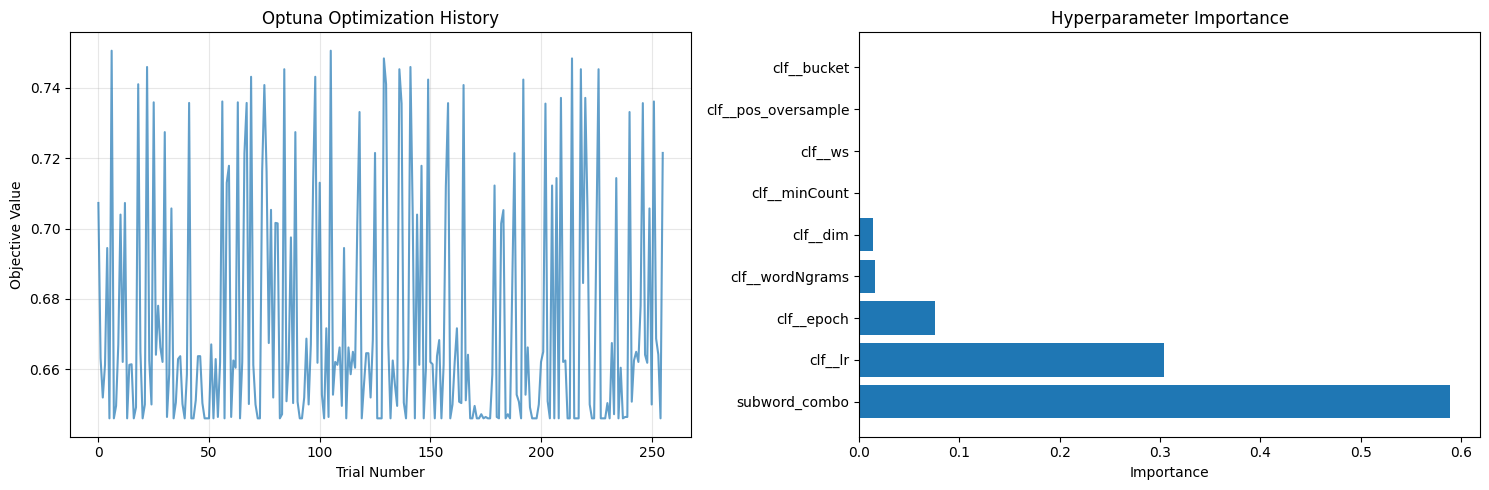


2. Parameter Value Distributions:


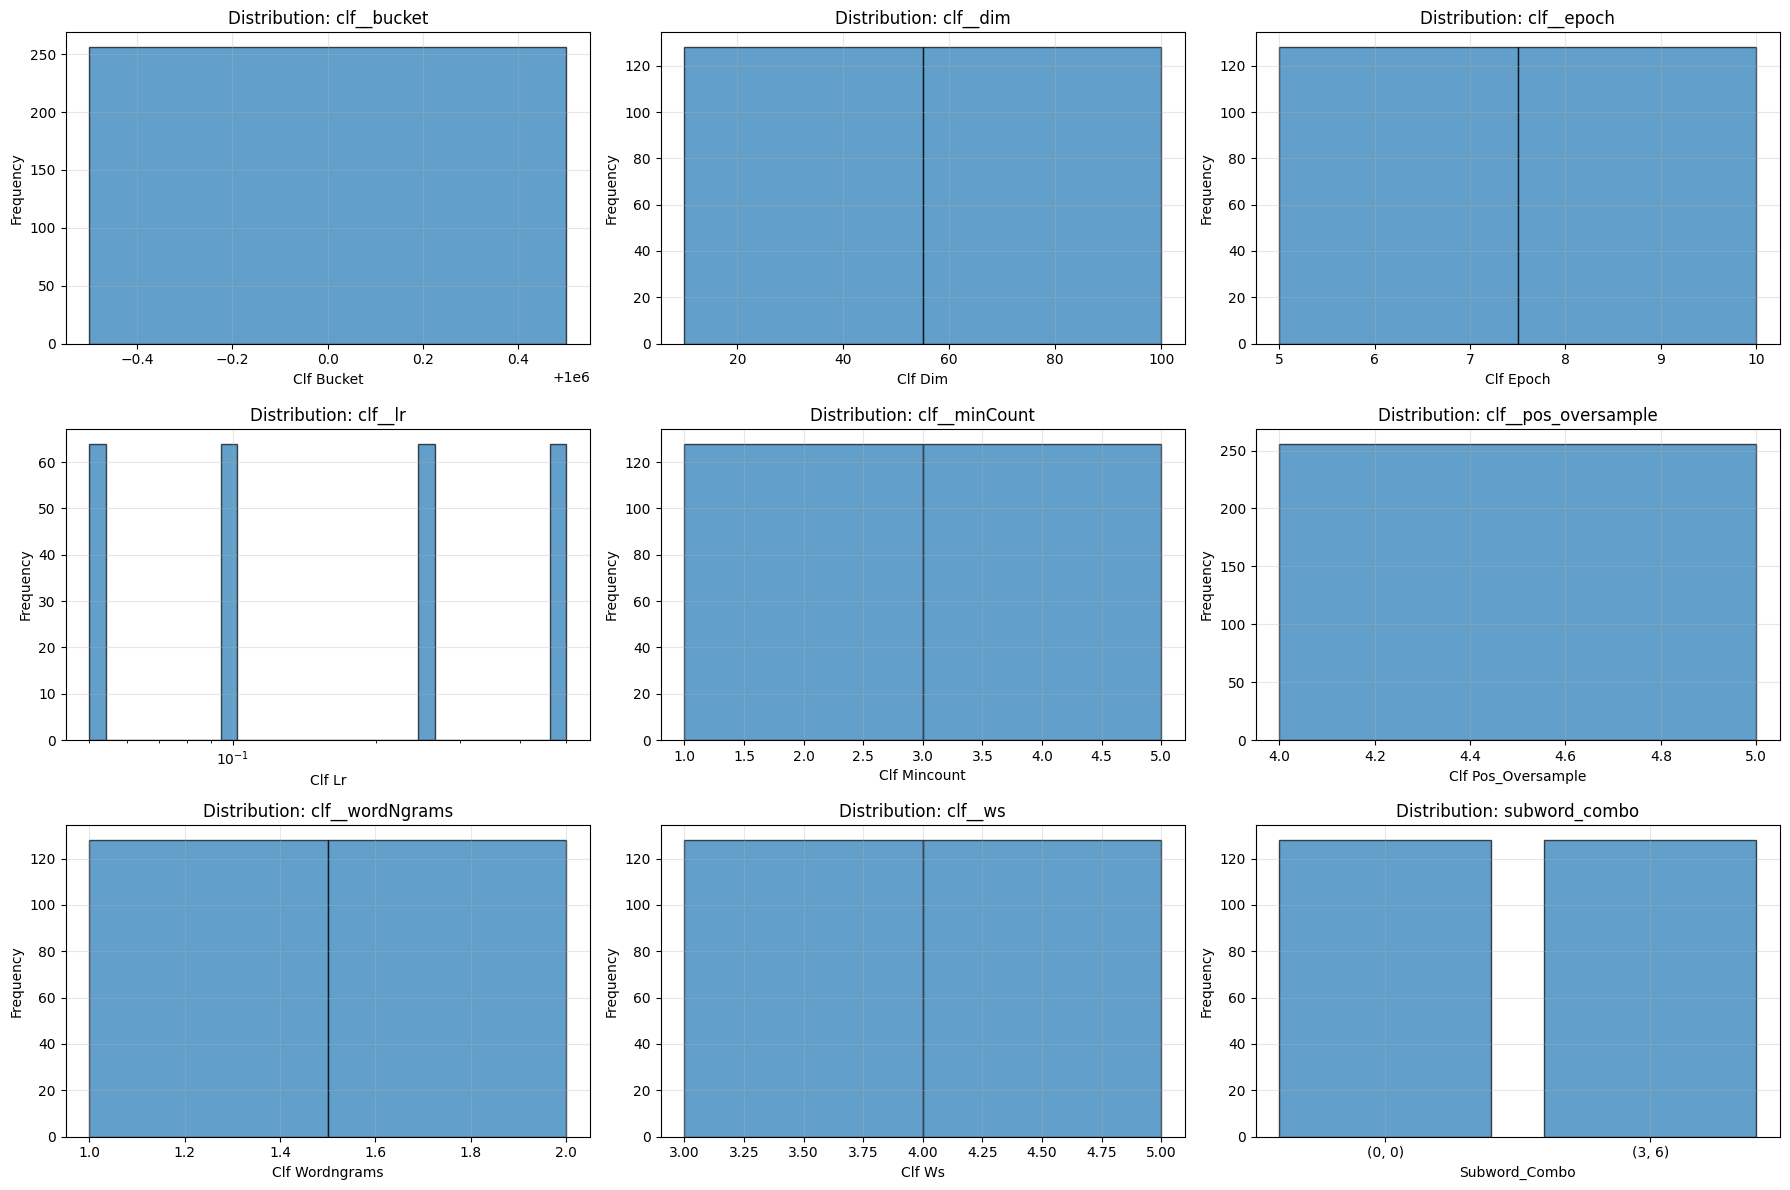


3. Performance vs Individual Parameters:


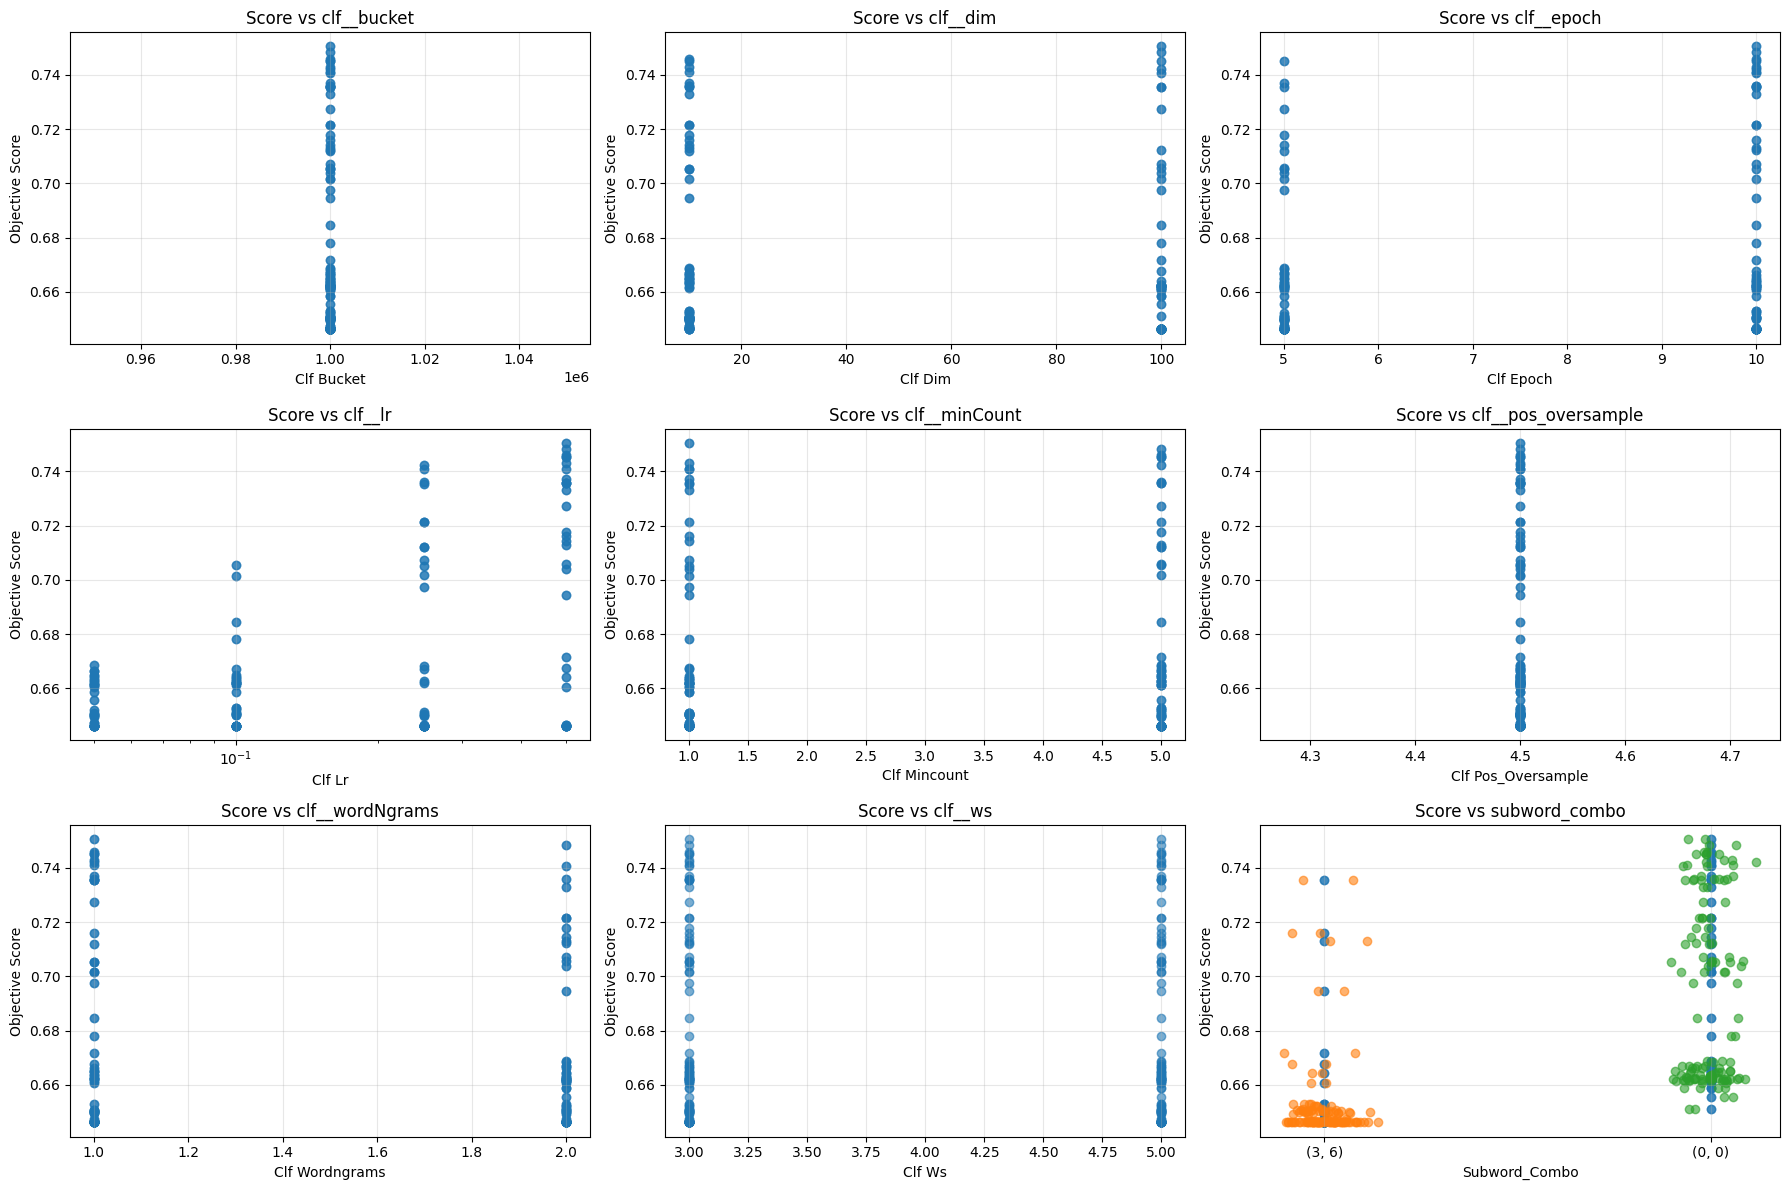


4. Convergence Analysis:


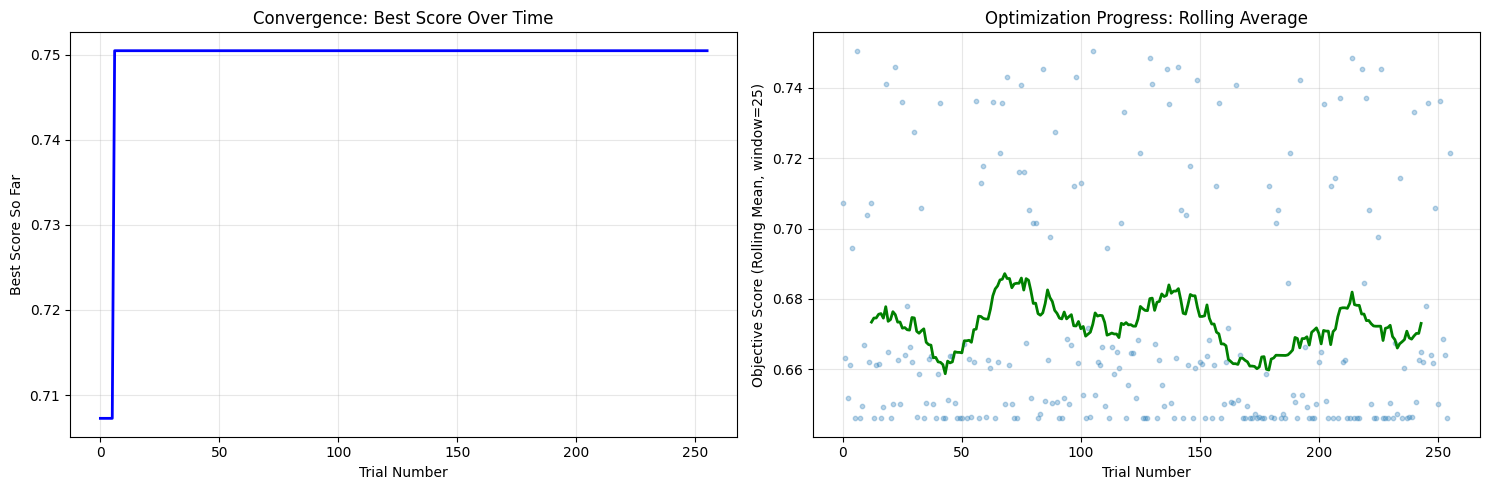


5. Trial Status Overview:


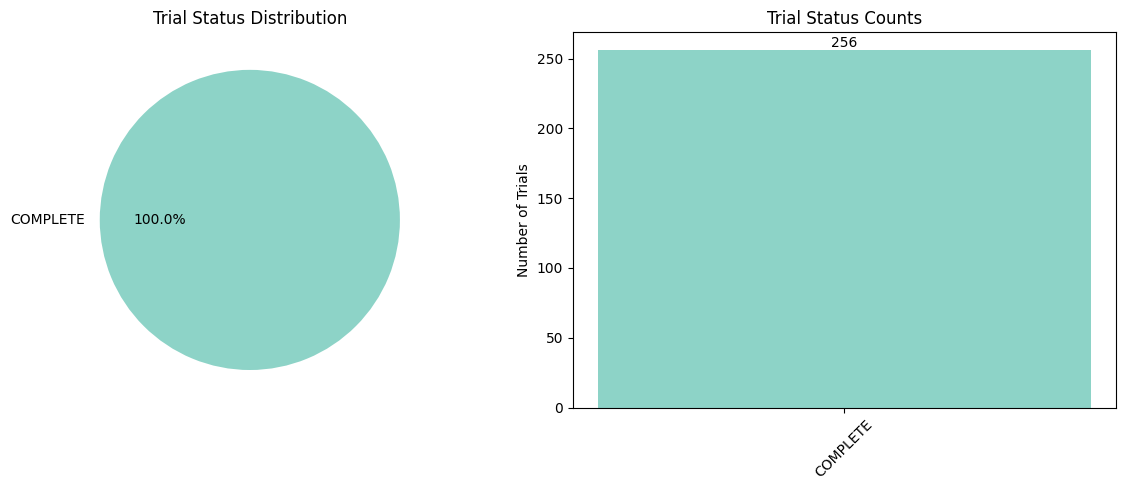


6. Top 10 Best Trials:
Rank Trial#  Score      bucket       dim          epoch        lr           minCount     pos_oversample wordNgrams   ws           subword_combo
-----------------------------------------------------------------------------------------------------------------------------------------------
1    6       0.7505     1000000      100          10           0.5000       1            4.5000       1            5            (0, 0)      
2    105     0.7505     1000000      100          10           0.5000       1            4.5000       1            3            (0, 0)      
3    129     0.7483     1000000      100          10           0.5000       5            4.5000       2            5            (0, 0)      
4    214     0.7483     1000000      100          10           0.5000       5            4.5000       2            3            (0, 0)      
5    22      0.7459     1000000      10           10           0.5000       5            4.5000       1            3        

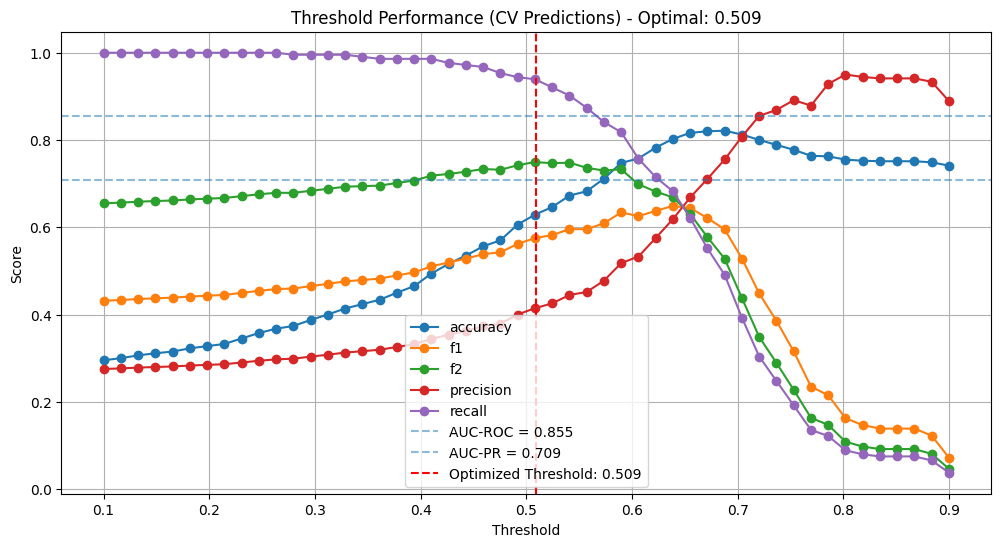

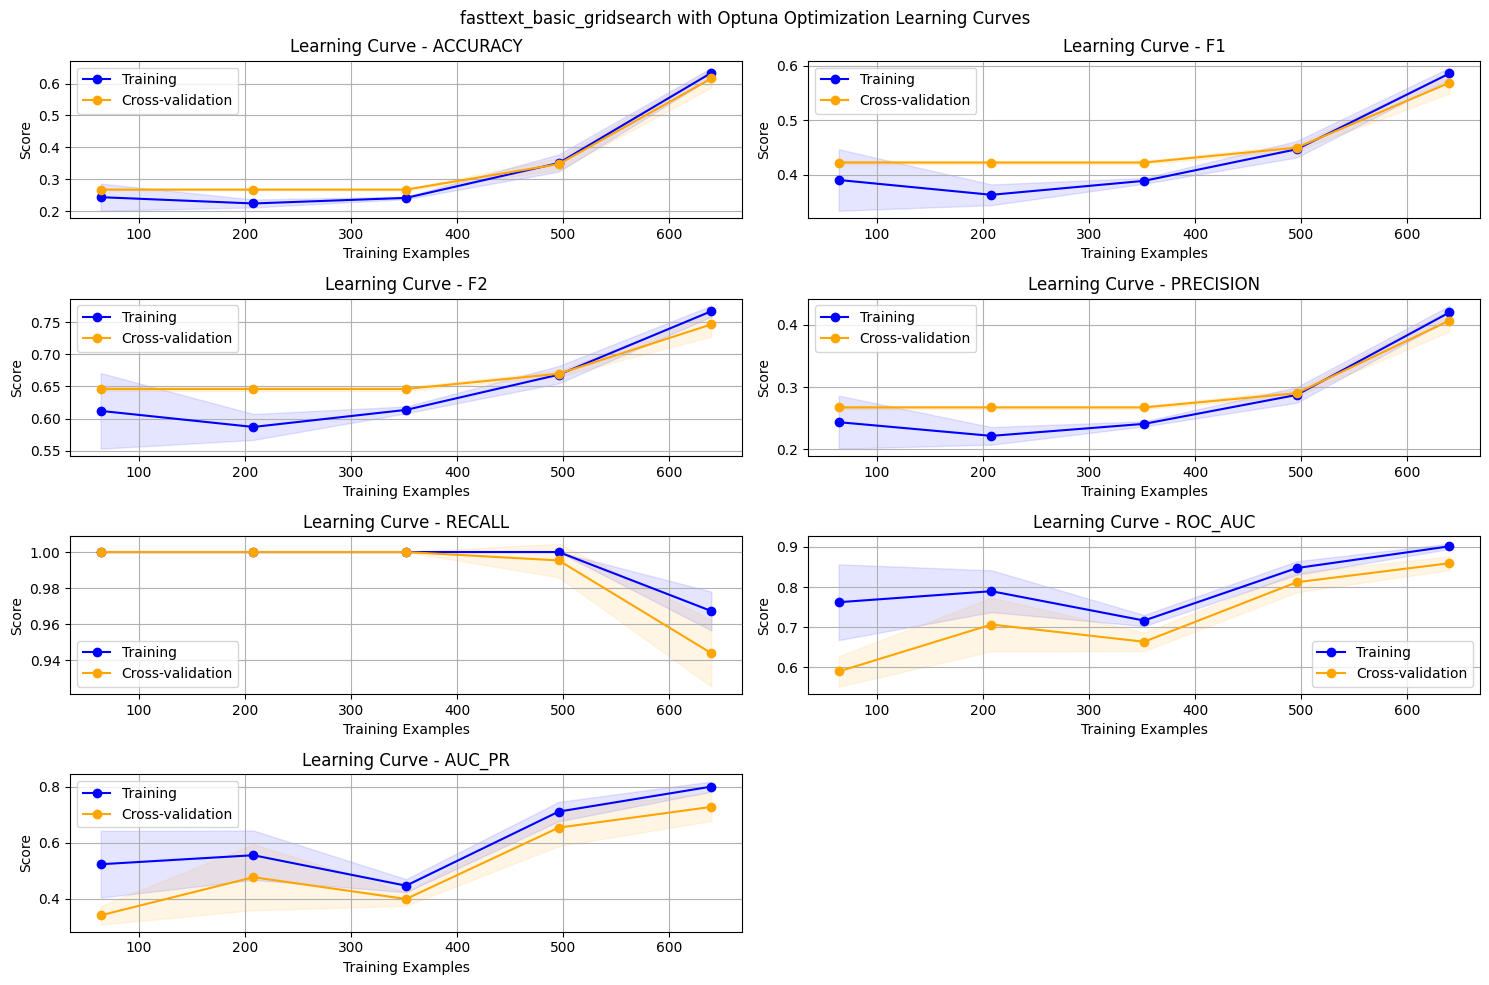


Final Threshold: 0.51
F2-score with default threshold (0.5): 0.779

Test Set Performance:
              precision    recall  f1-score   support

           0       0.95      0.64      0.77       146
           1       0.49      0.91      0.63        54

    accuracy                           0.71       200
   macro avg       0.72      0.78      0.70       200
weighted avg       0.82      0.71      0.73       200

Additional Metrics:
Accuracy   0.715
F2-score   0.773
AUC-ROC    0.868
AUC-PR     0.743



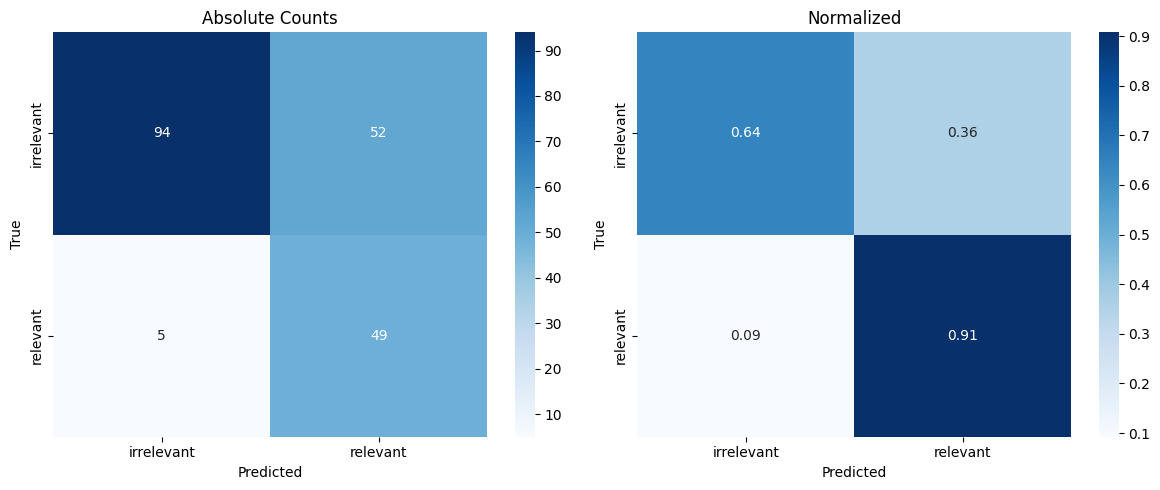

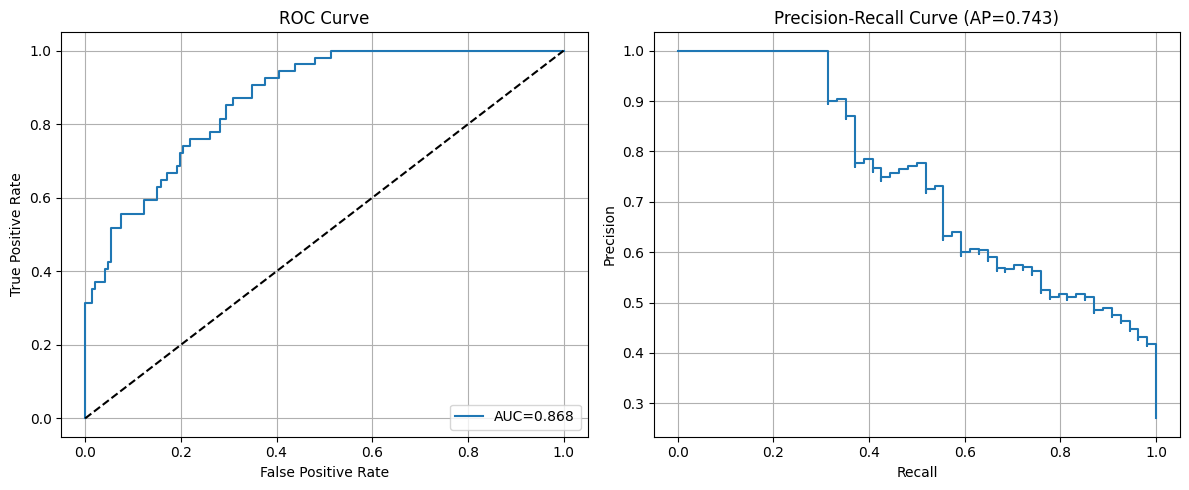


Model saved as model_fasttext_basic_gridsearch.joblib


In [6]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

pipeline_fasttext = Pipeline([
    # no more steps, because we use fasttext as end-to-end model here
    ("clf", FastTextSklearnClassifier(
        lr=0.1, 
        dim=100, 
        epoch=5, 
        ws=5,
        wordNgrams=2, 
        minn=2, 
        maxn=4, 
        minCount=2,
        neg=10, 
        thread=1,  # reproducibility
        loss="softmax",
    ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space 
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
# GridSearchCV: paper-faithful, compact grid.
param_grid = {
    # Paper sweep for learning rate {0.05, 0.1, 0.25, 0.5}.
    "clf__lr": [0.05, 0.1, 0.25, 0.5],

    # Hidden size ("dim"): h=10 used in paper for sentiment; add 100 as pragmatic option.
    "clf__dim": [10, 100],

    # Paper trains for 5 epochs on sentiment; keep 5, allow 10 as a tiny extension.
    "clf__epoch": [5, 10],

    # Context window; use a stable middle value and a slightly narrower option.
    "clf__ws": [3, 5],

    # Bigrams add 1–4% in the paper; try uni- vs. bi-grams.
    "clf__wordNgrams": [1, 2],

    # Subwords: paper recommends char n-grams; test OFF vs. (3,6).
    "subword_combo": [(0, 0), (3, 6)],

    # Keep vocabulary pruning modest to speed up training.
    "clf__minCount": [1, 5],

    # Keep bucket size reasonable; extremely large buckets can hurt IO/memory.
    "clf__bucket": [1_000_000],

    # Imbalance handling: Set around optimum of first tpe search
    "clf__pos_oversample": [4.5],
}


model_name = "fasttext_basic_gridsearch"

#grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_fasttext,
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10),
    n_jobs=1
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")



**b) FastText based on advanced preprocessed data**

In [7]:
# Load and preprocess data (advanced mode)
df_advancedcleaned = process_file(
    filepath=f'{root_path}/05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='advanced'  # basic cleaning mode
)

# Map labels to binary values
df_advancedcleaned['Label'] = df_advancedcleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

FastText TPE advanced

Starting Optuna hyperparameter optimization ...


c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0) which is of type tuple.
  warnings.warn(message)
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (2, 4) which is of type tuple.
  warnings.warn(message)
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\distributi

Best parameters found by Optuna TPE: {'clf__lr': 0.20323972804324492, 'clf__dim': 50, 'clf__epoch': 10, 'clf__ws': 3, 'clf__wordNgrams': 1, 'clf__minCount': 5, 'subword_combo': (0, 0), 'clf__pos_oversample': 4.4113441536044995}
Best F2 score during optimization: 0.809

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


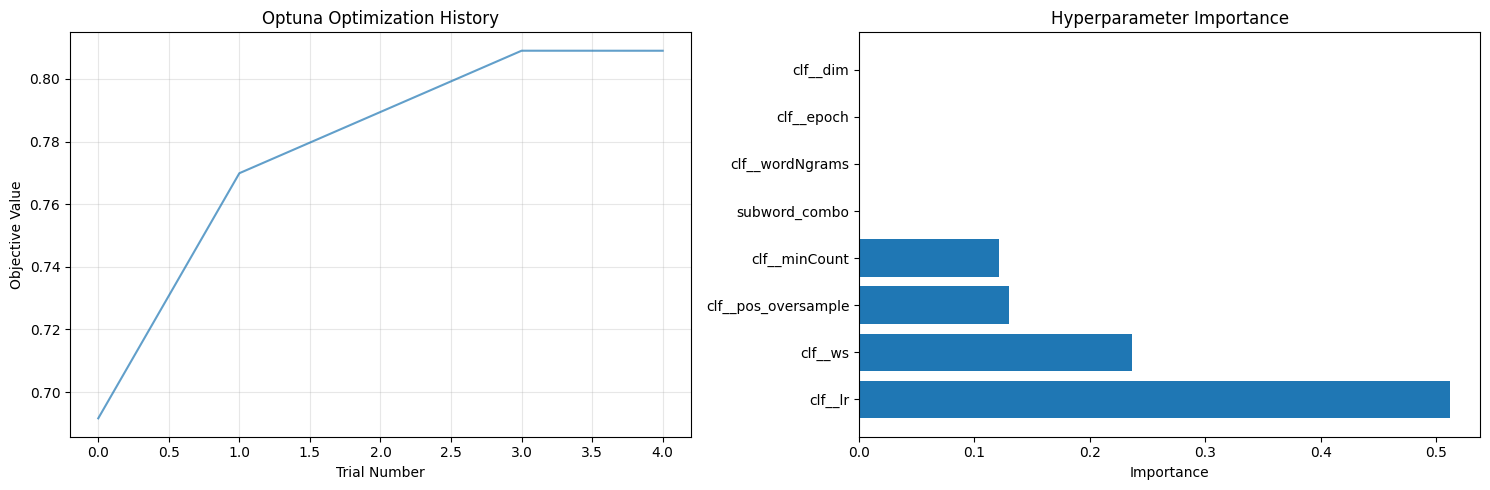


2. Parameter Value Distributions:


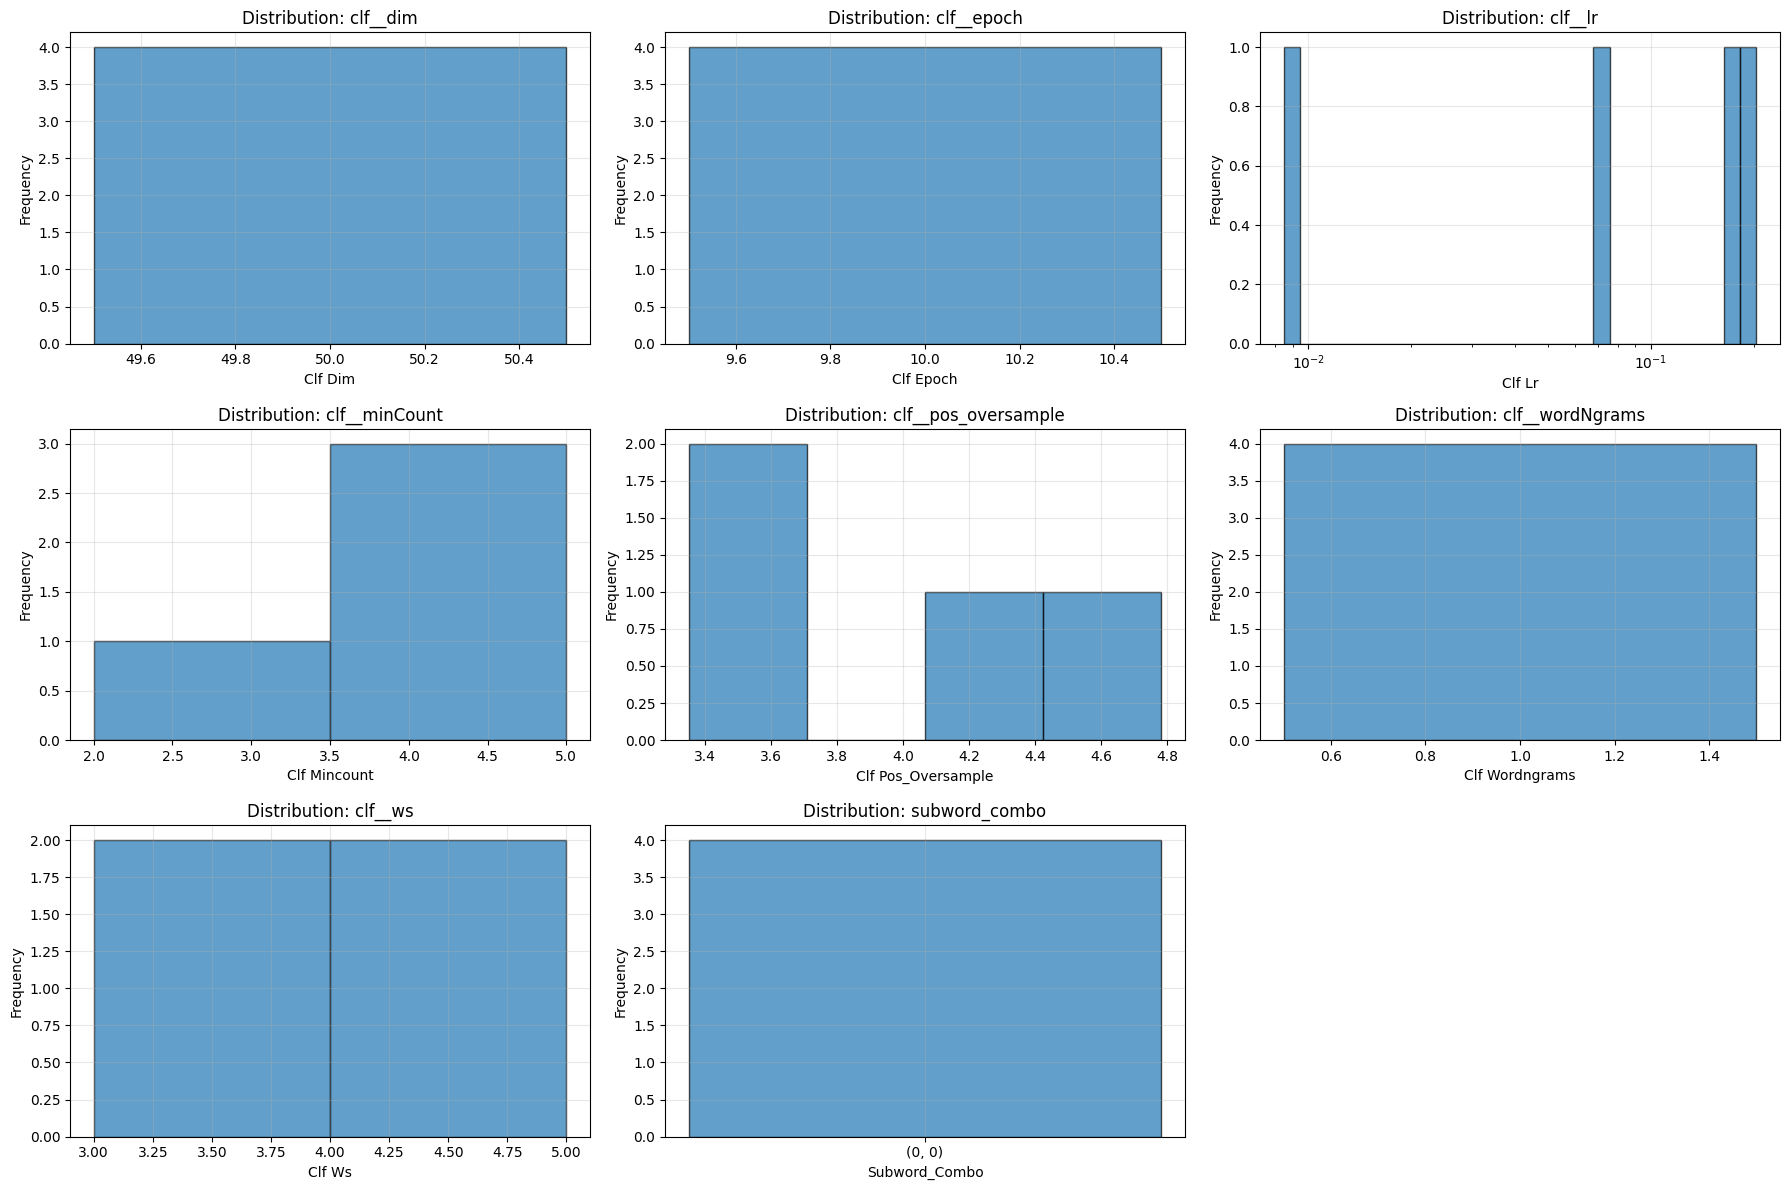


3. Performance vs Individual Parameters:


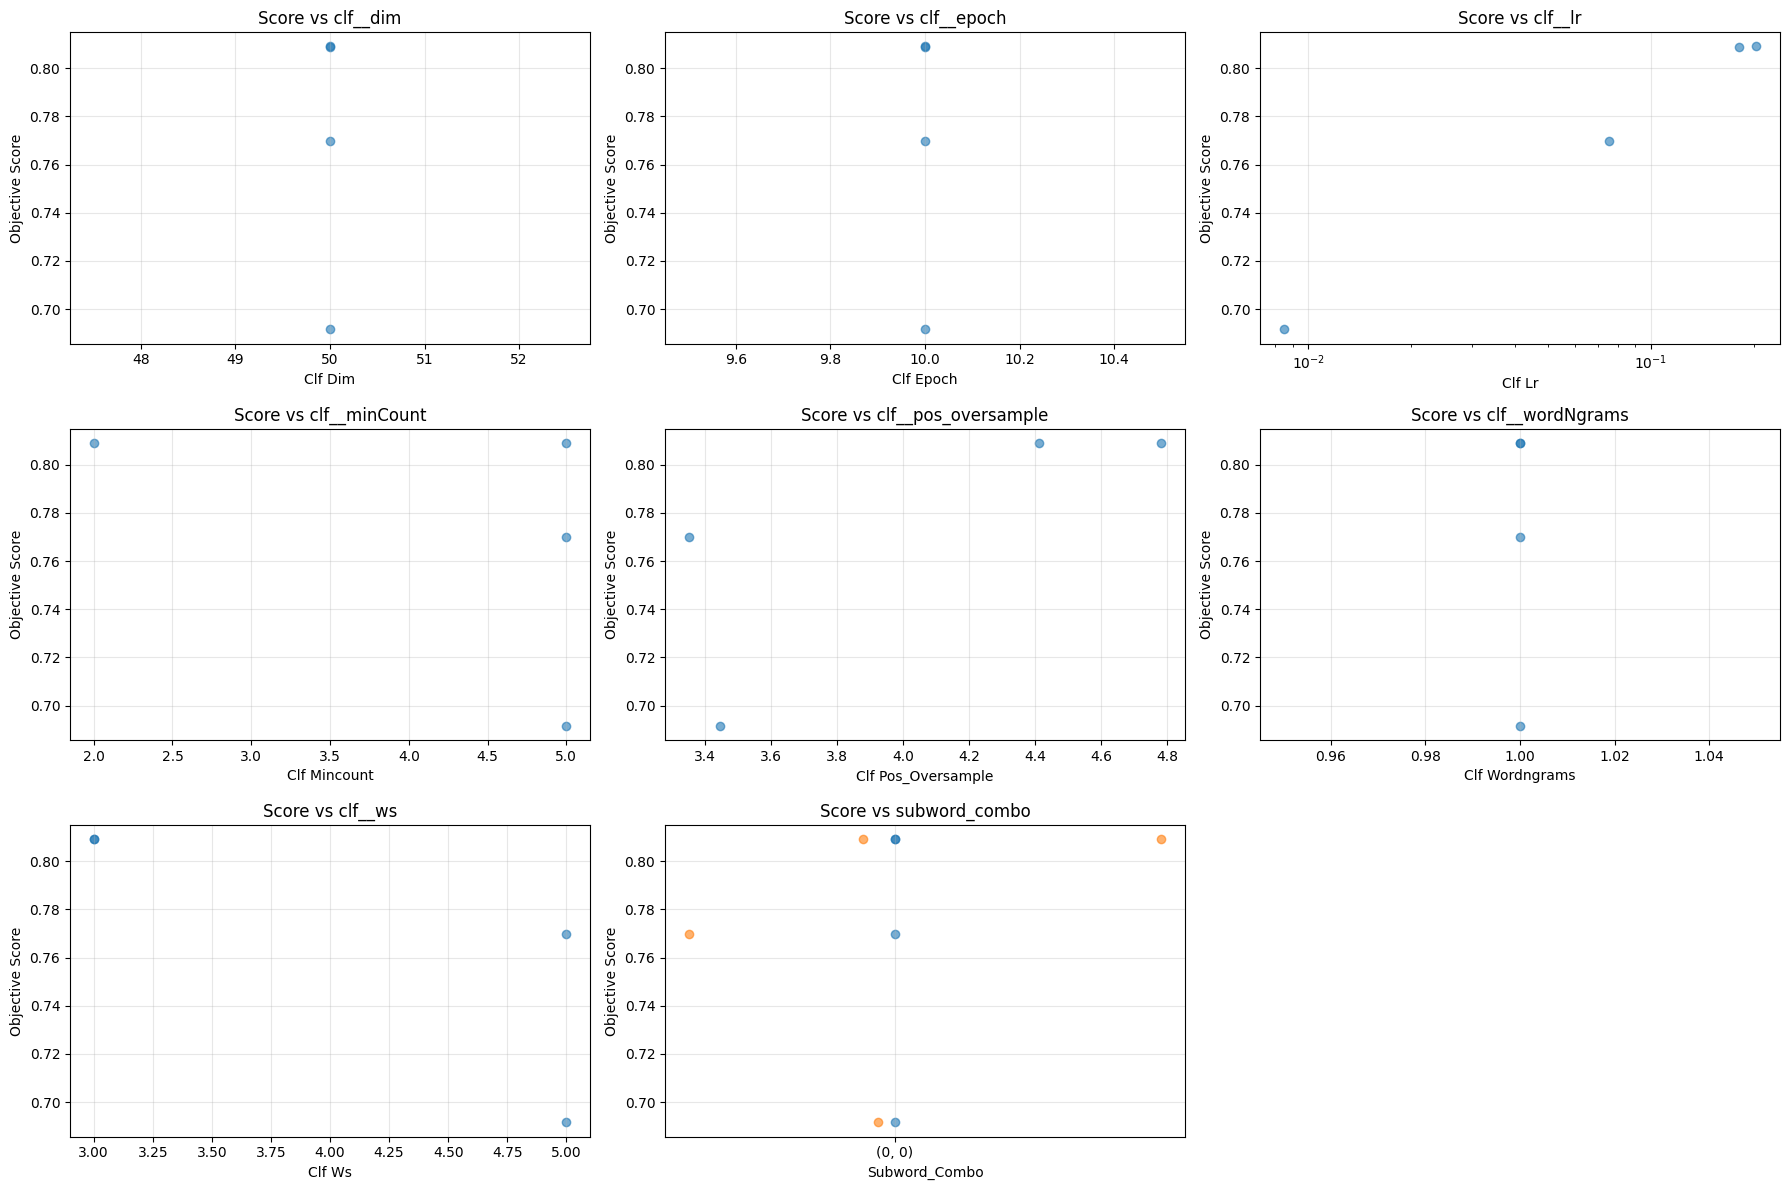


4. Convergence Analysis:


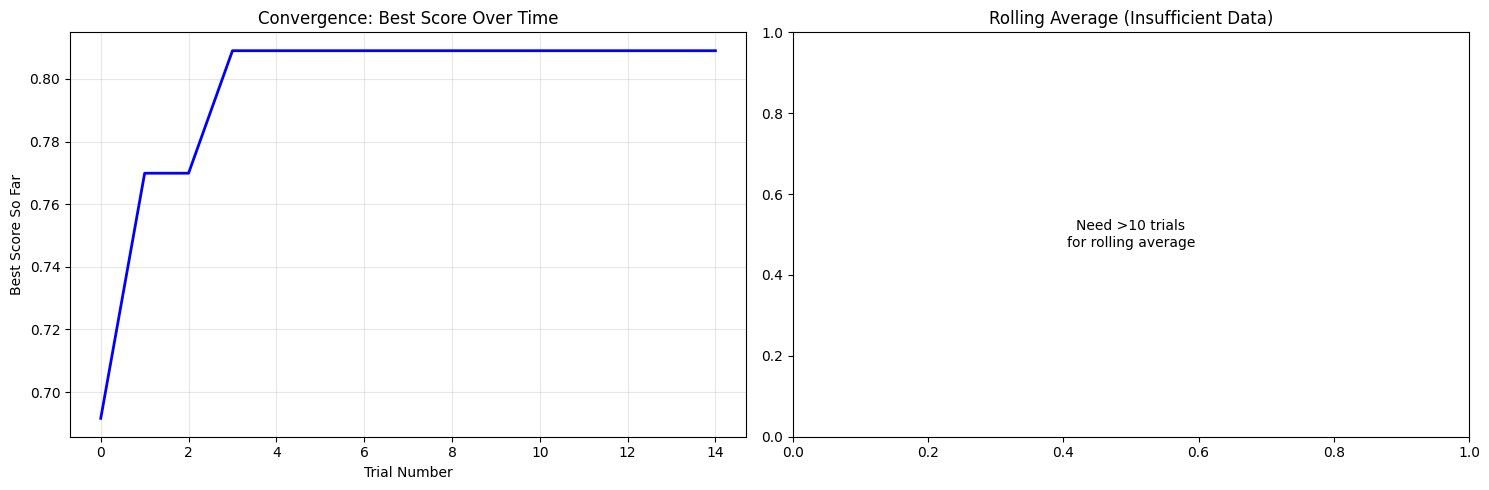


5. Trial Status Overview:


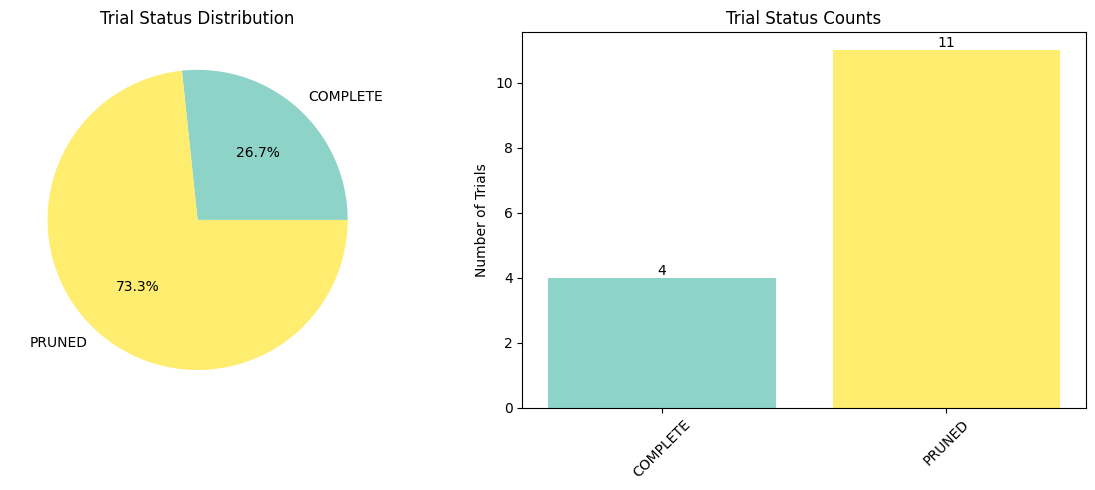


6. Top 10 Best Trials:
Rank Trial#  Score      dim          epoch        lr           minCount     pos_oversample wordNgrams   ws           subword_combo
----------------------------------------------------------------------------------------------------------------------------------
1    3       0.8090     50           10           0.2032       5            4.4113       1            3            (0, 0)      
2    4       0.8090     50           10           0.1804       2            4.7826       1            3            (0, 0)      
3    1       0.7699     50           10           0.0755       5            3.3518       1            5            (0, 0)      
4    0       0.6916     50           10           0.0085       5            3.4474       1            5            (0, 0)      

7. Study Statistics Summary:
• Total trials: 15
• Successful trials: 4
• Failed trials: 0
• Success rate: 26.7%
• Best trial: #3
• Best objective value: 0.8090
• Score statistics:
  - Mean: 0.6285
  - 

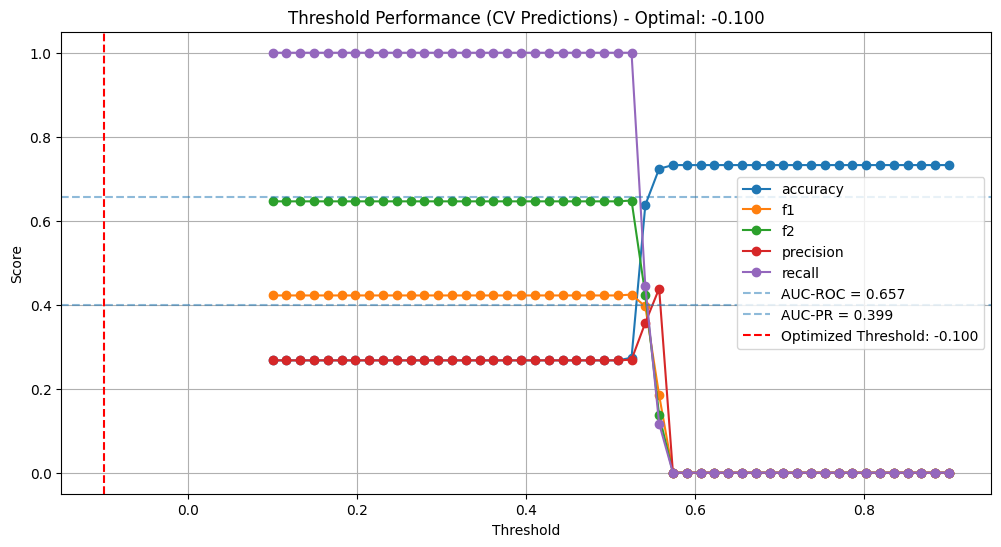

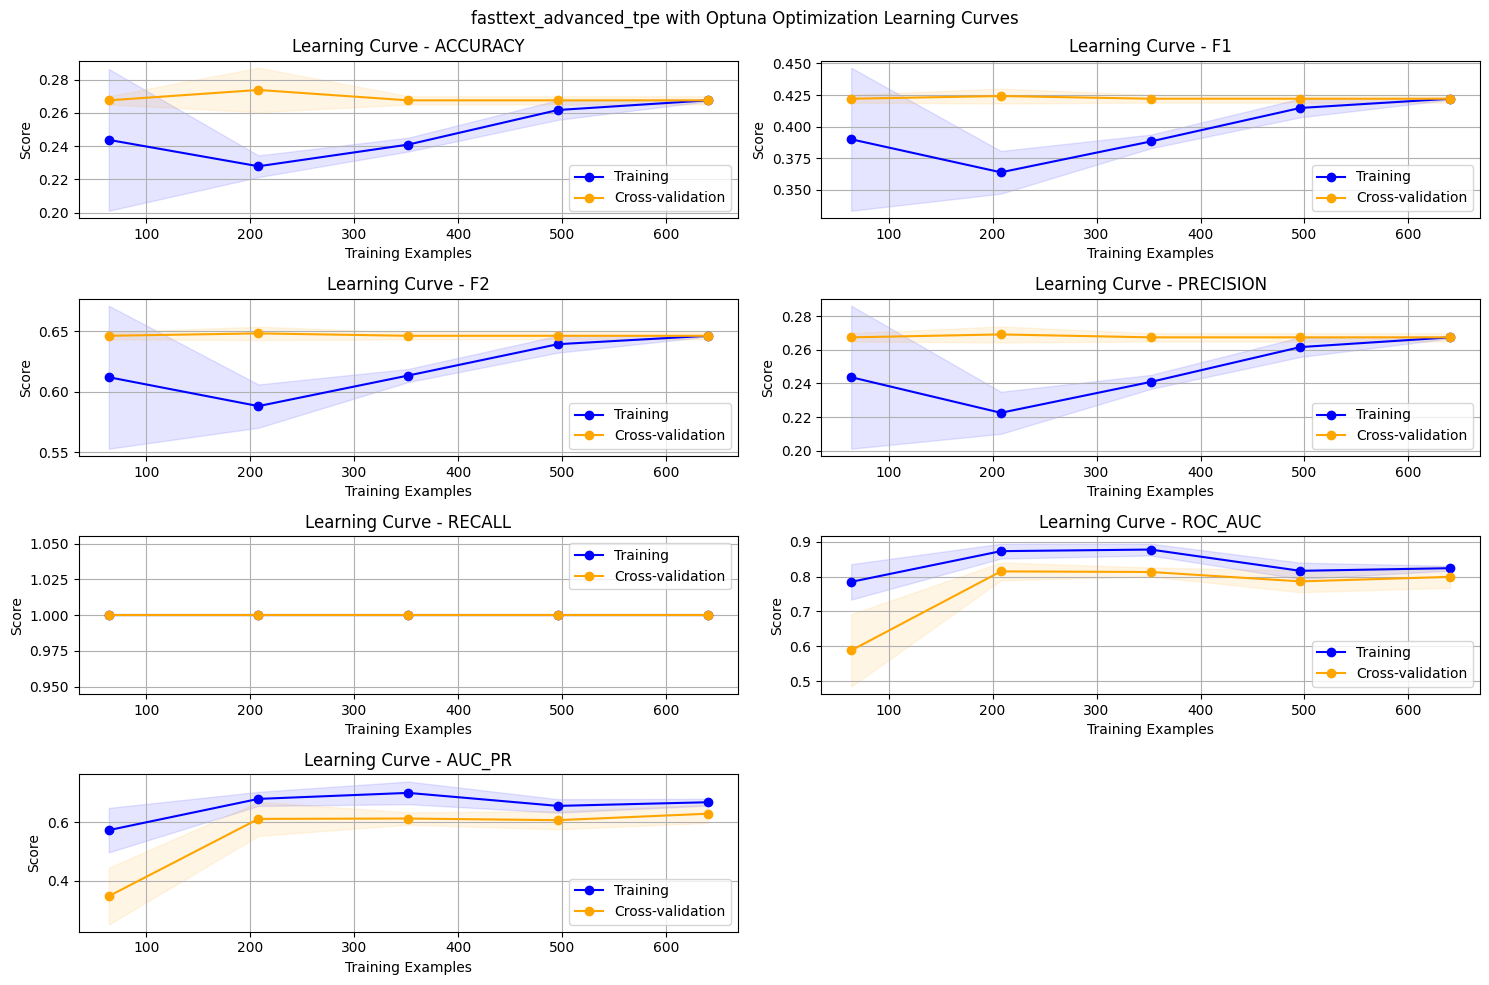


Final Threshold: -0.10
F2-score with default threshold (0.5): 0.649

Test Set Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       146
           1       0.27      1.00      0.43        54

    accuracy                           0.27       200
   macro avg       0.14      0.50      0.21       200
weighted avg       0.07      0.27      0.11       200

Additional Metrics:
Accuracy   0.270
F2-score   0.649
AUC-ROC    0.854
AUC-PR     0.723



c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


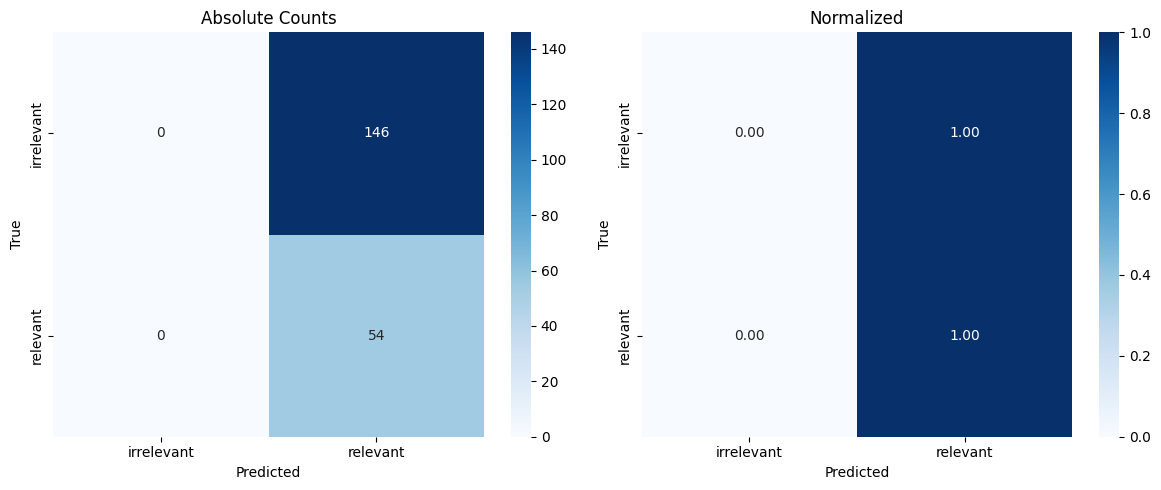

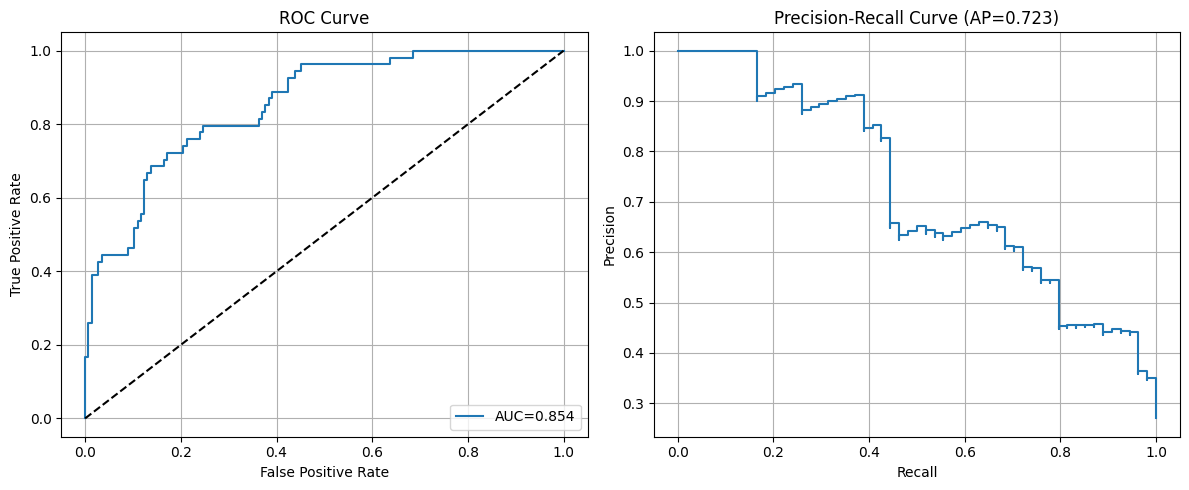

c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\tdoro\miniconda3


Model saved as model_fasttext_advanced_tpe.joblib


In [8]:
#perform train-test split on advanced cleaned data
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

pipeline_fasttext = Pipeline([
    # no more steps, because we use fasttext as end-to-end model here
    ("clf", FastTextSklearnClassifier(
        lr=0.1, 
        dim=100, 
        epoch=10, 
        ws=5,
        wordNgrams=2, 
        minn=2, 
        maxn=4, 
        minCount=2,
        neg=10, 
        thread=1,  # reproducibility
        loss="softmax",
        bucket=1_000_000, 
    ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space 
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
param_space = {
    # (Joulin et al.: LR, Dim, n-grams, Subwords)
    "clf__lr":           (lambda t: t.suggest_float("clf__lr", 1e-3, 3e-1, log=True)),
    "clf__dim":          (lambda t: t.suggest_categorical("clf__dim", [50, 100, 150, 200, 300])),
    "clf__epoch":        (lambda t: t.suggest_categorical("clf__epoch", [5, 10])),  # cap 10
    "clf__ws":           (lambda t: t.suggest_categorical("clf__ws", [3, 5, 7])),
    "clf__wordNgrams":   (lambda t: t.suggest_categorical("clf__wordNgrams", [1, 2, 3])),
    "clf__minCount":     (lambda t: t.suggest_categorical("clf__minCount", [1, 2, 5])),

    # Subword-Combinations (minn/maxn coupled)
    "clf__minn": (lambda t: t.suggest_categorical("subword_combo", [(0,0), (2,4), (3,6)])[0]),
    "clf__maxn": (lambda t: t.suggest_categorical("subword_combo", [(0,0), (2,4), (3,6)])[1]),

    #against imbalance
    "clf__pos_oversample": (lambda t: t.suggest_float("clf__pos_oversample", 1.0, 5.0))
}

model_name = "fasttext_advanced_tpe"

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna_tpe(
    estimator=pipeline_fasttext,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    model_type = "fasttext",
    n_trials=15, #we reduce the number of trials as we have many categorical HP Values
    n_startup_trials=1, # less aggressive prunning
    n_warmup_steps=0, #first !trial! not pruned - we can´t prune after epochjs, as fasttext doesn´t enable it
    intervall_steps=1, # prunning possible for every epoch
    direction="maximize",
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name=model_name
)
print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10),
    n_jobs=1
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")


FastText GridSearch advanced
- Note: We don´t perform TPE Search on advanced preprocessed data due to low performance in basic preprocessing. We will just copy the paper settings from joulin et al 2016 with some variation (as already did in FastText basic GridSearch)
Possible Reasons for long training time: 
- no GPU use possible
- no EarlyStopping/EpochPrunning Possible

Starting Optuna hyperparameter optimization ...


c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\samplers\_grid.py:232: UserWarning: subword_combo contains a value with the type of <class 'tuple'>, which is not supported by `GridSampler`. Please make sure a value is `str`, `int`, `float`, `bool` or `None` for persistent storage.
  warnings.warn(message)
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (0, 0) which is of type tuple.
  warnings.warn(message)
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 6) which is of type tuple.
  warnings.warn(message)
c:\Users\tdoro\miniconda3\Lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, 

Best parameters found by Optuna TPE: {'clf__lr': 0.5, 'clf__dim': 100, 'clf__epoch': 5, 'clf__ws': 3, 'clf__wordNgrams': 1, 'subword_combo': (0, 0), 'clf__minCount': 1, 'clf__bucket': 2000000, 'clf__pos_oversample': 4.5}
Best F2 score during optimization: 0.800

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


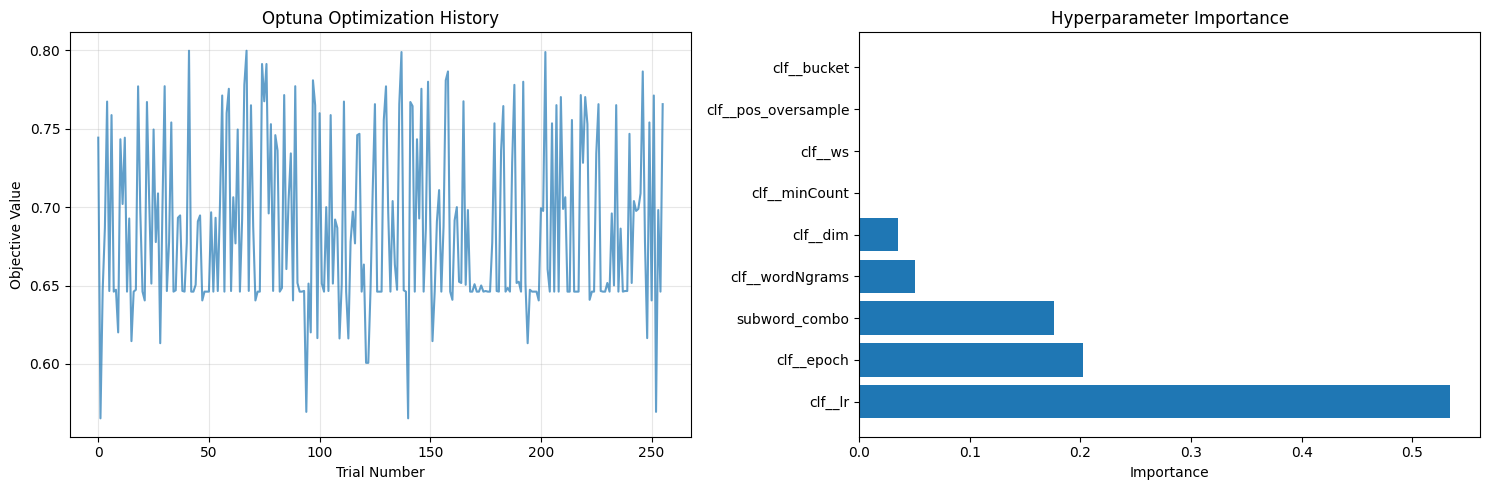


2. Parameter Value Distributions:


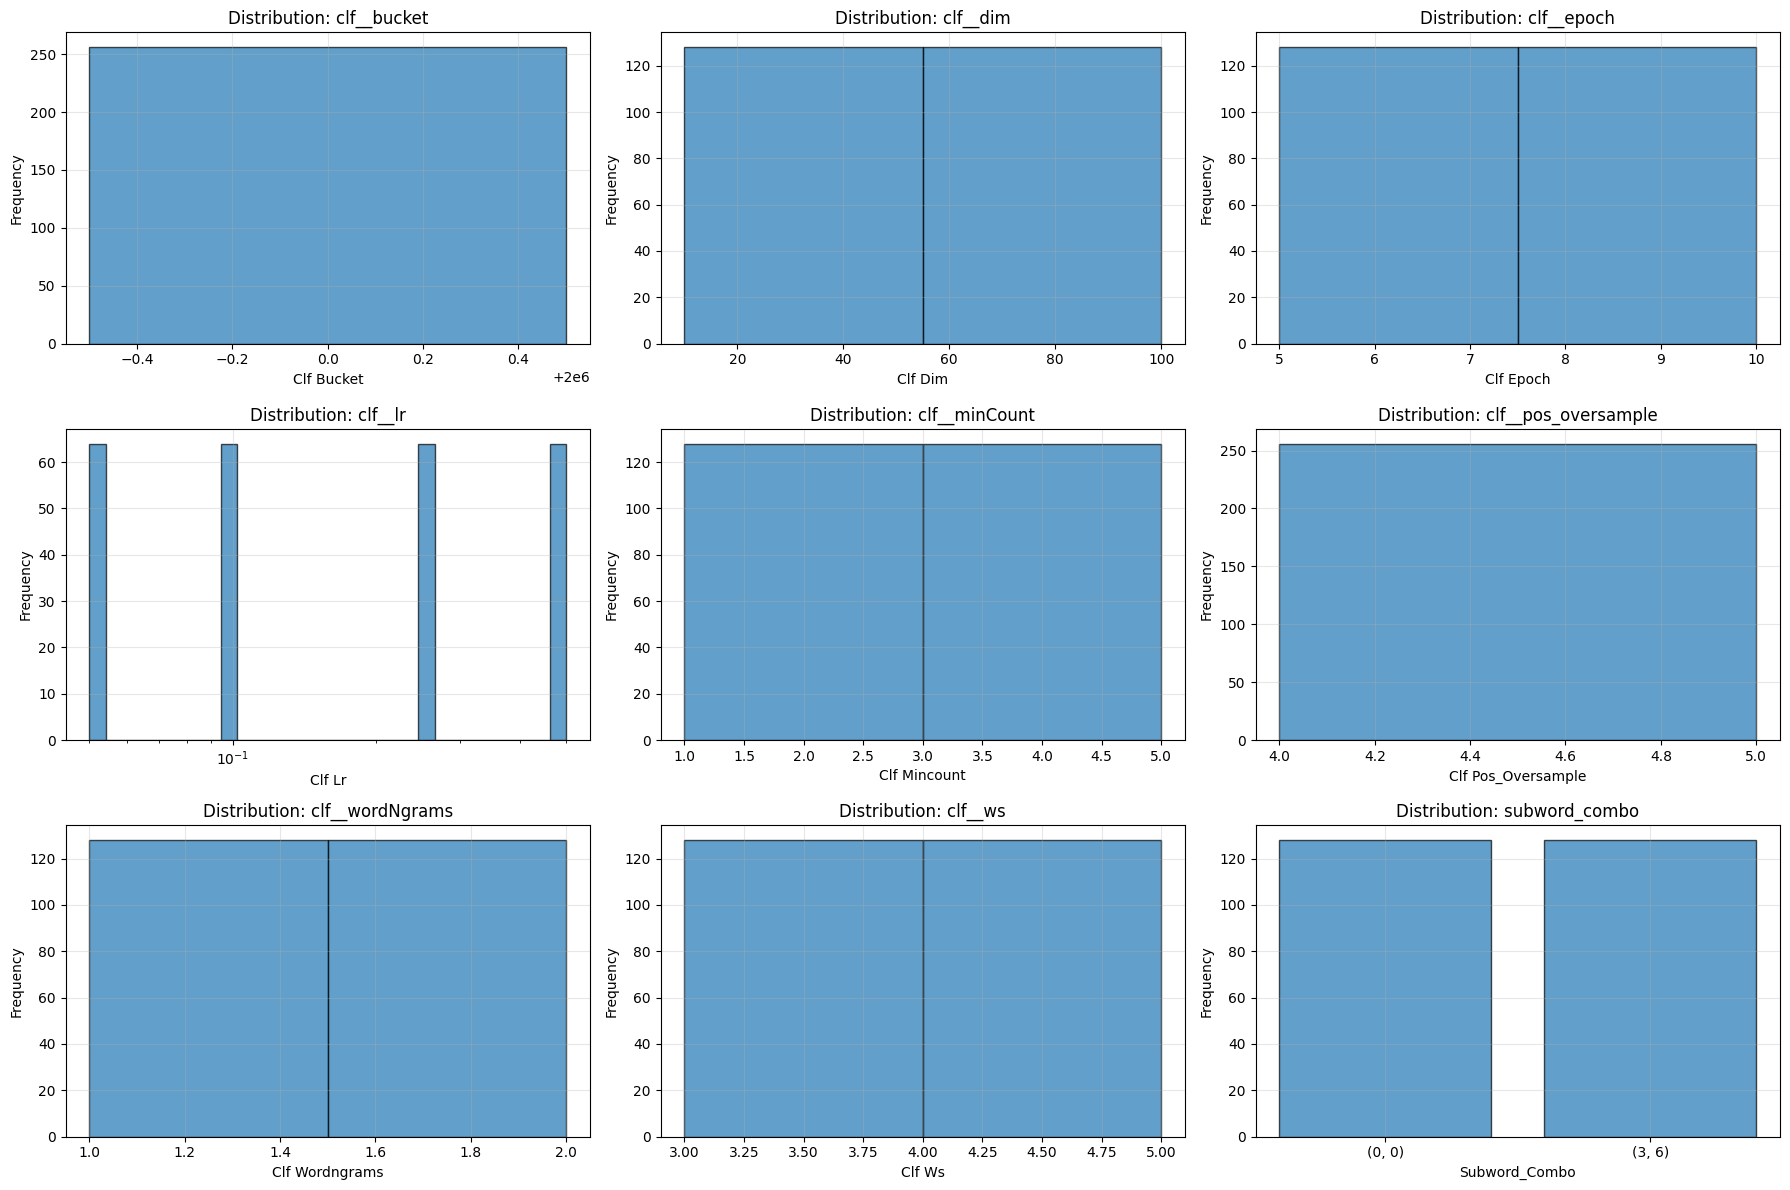


3. Performance vs Individual Parameters:


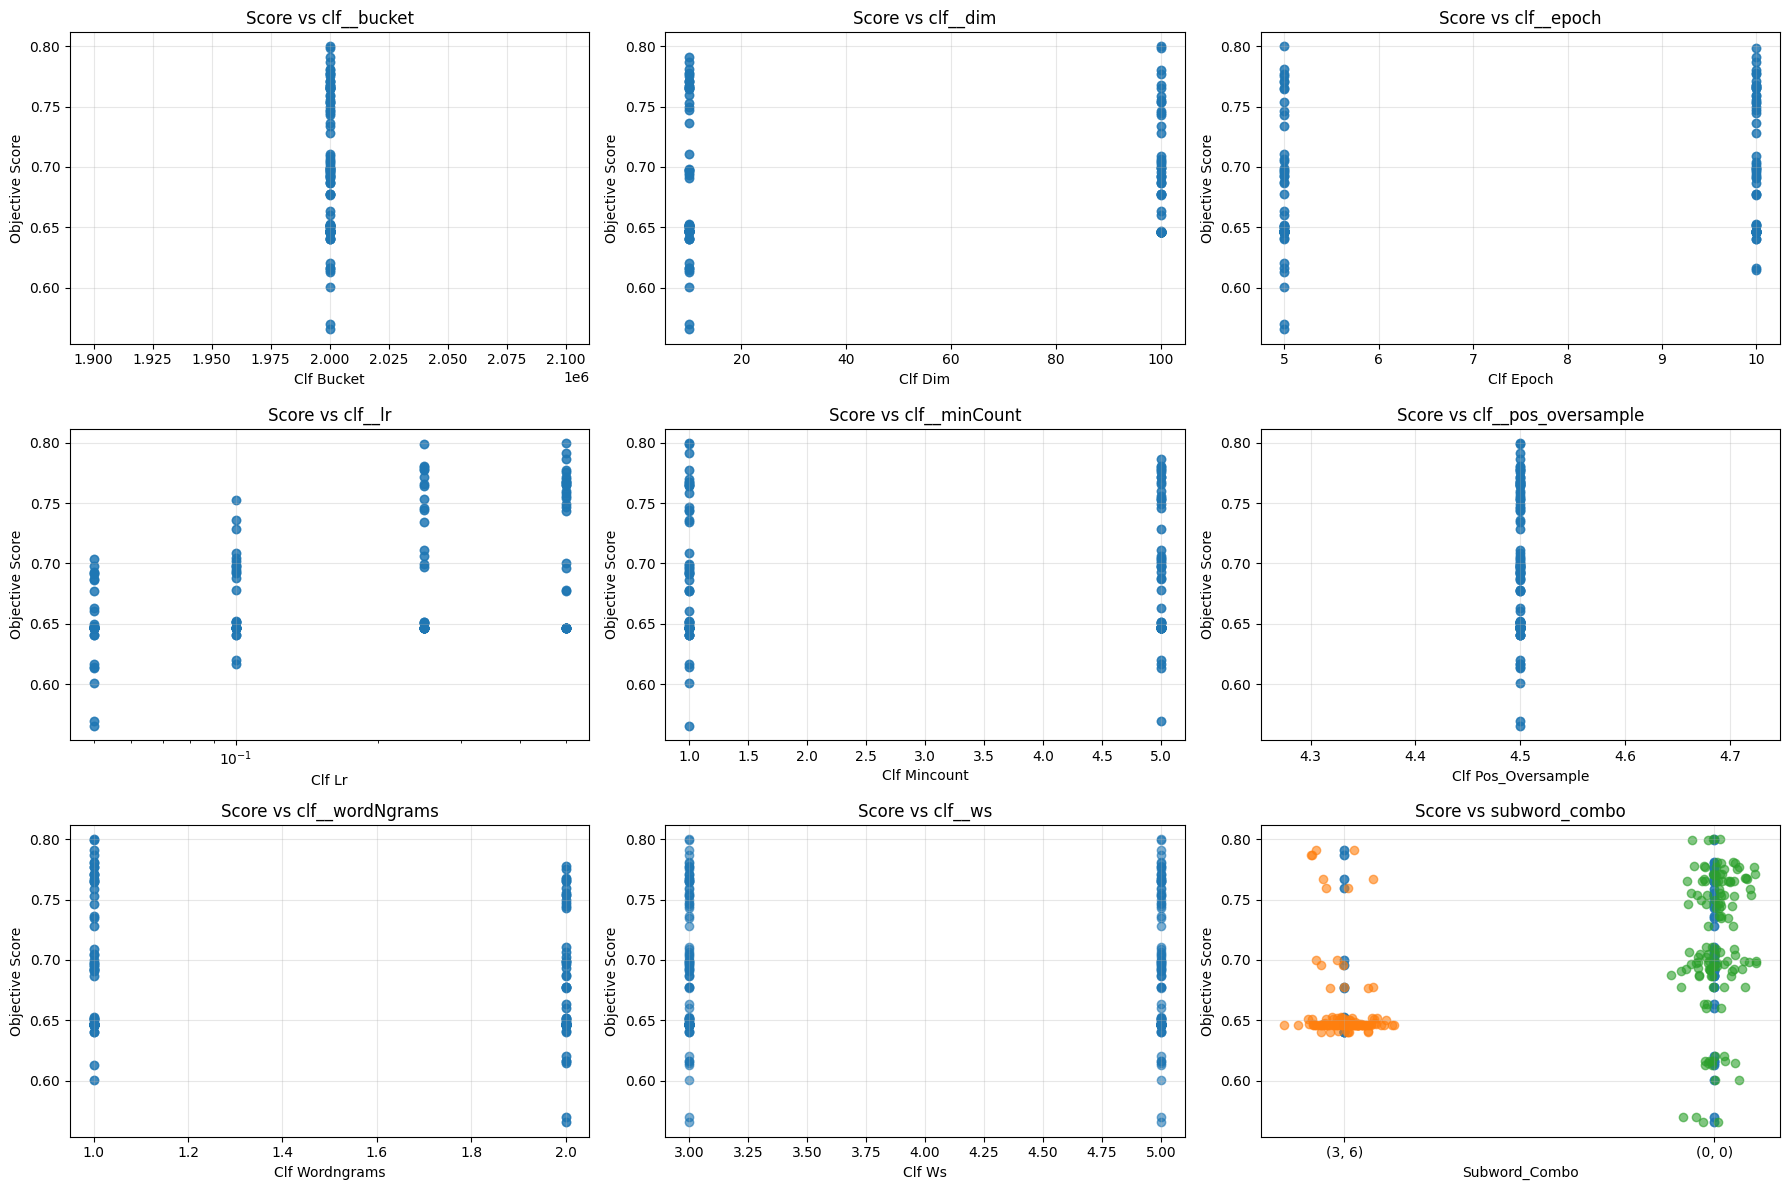


4. Convergence Analysis:


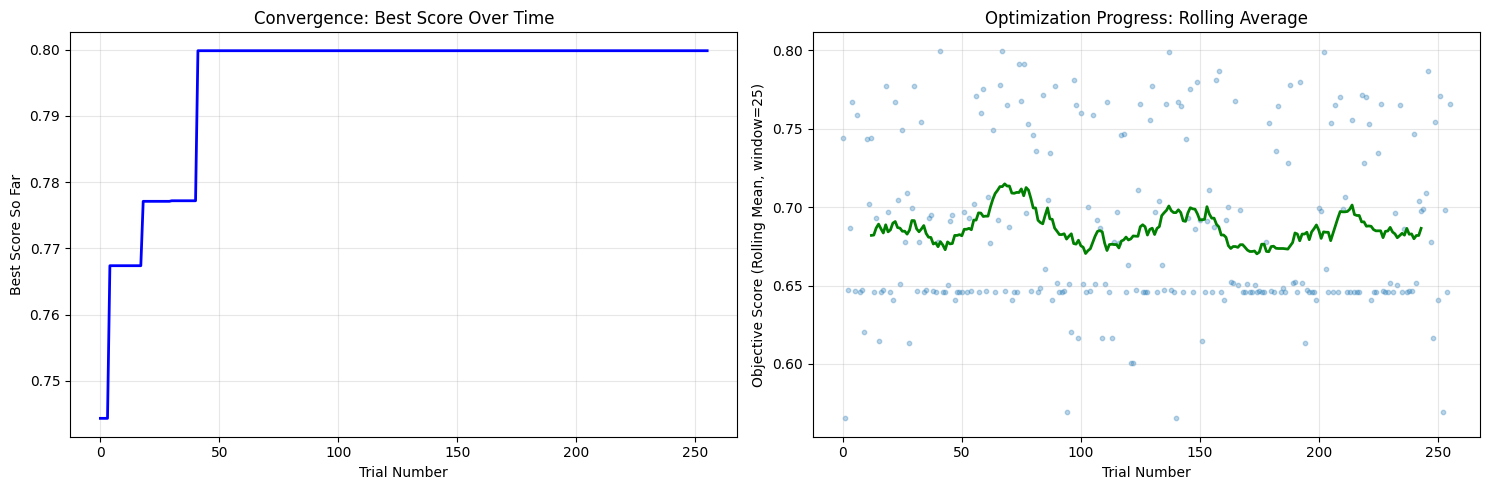


5. Trial Status Overview:


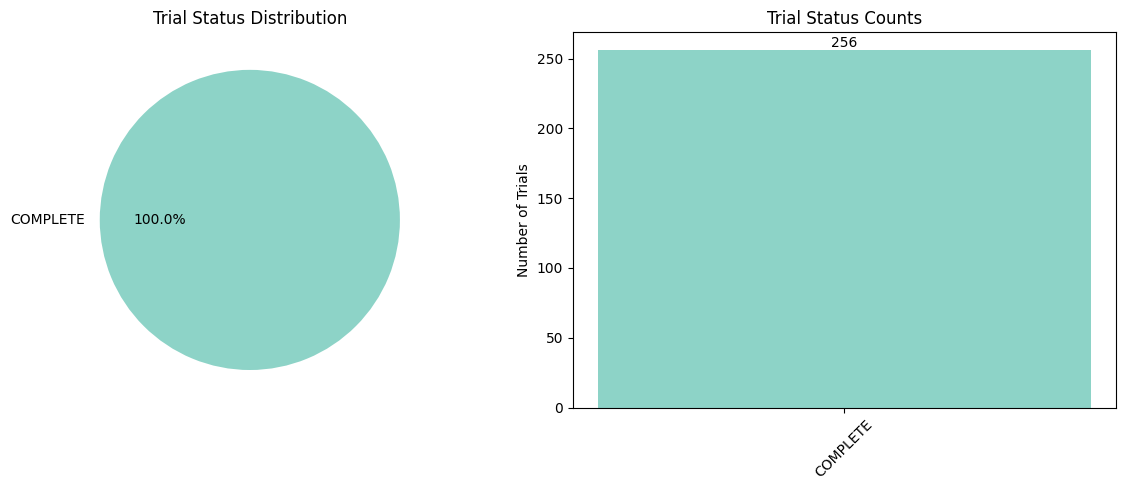


6. Top 10 Best Trials:
Rank Trial#  Score      bucket       dim          epoch        lr           minCount     pos_oversample wordNgrams   ws           subword_combo
-----------------------------------------------------------------------------------------------------------------------------------------------
1    41      0.7998     2000000      100          5            0.5000       1            4.5000       1            3            (0, 0)      
2    67      0.7998     2000000      100          5            0.5000       1            4.5000       1            5            (0, 0)      
3    137     0.7990     2000000      100          10           0.2500       1            4.5000       1            3            (0, 0)      
4    202     0.7990     2000000      100          10           0.2500       1            4.5000       1            5            (0, 0)      
5    74      0.7914     2000000      10           10           0.5000       1            4.5000       1            5        

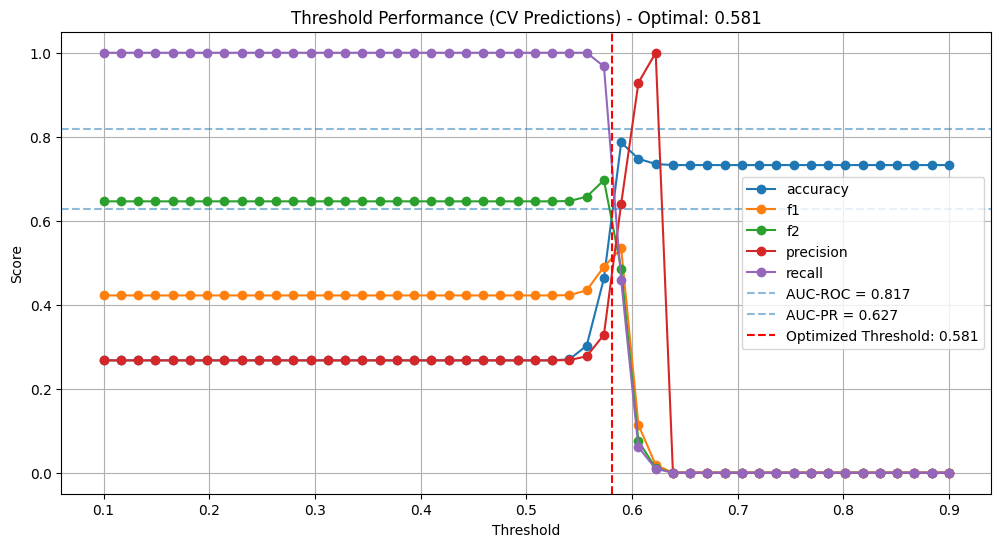

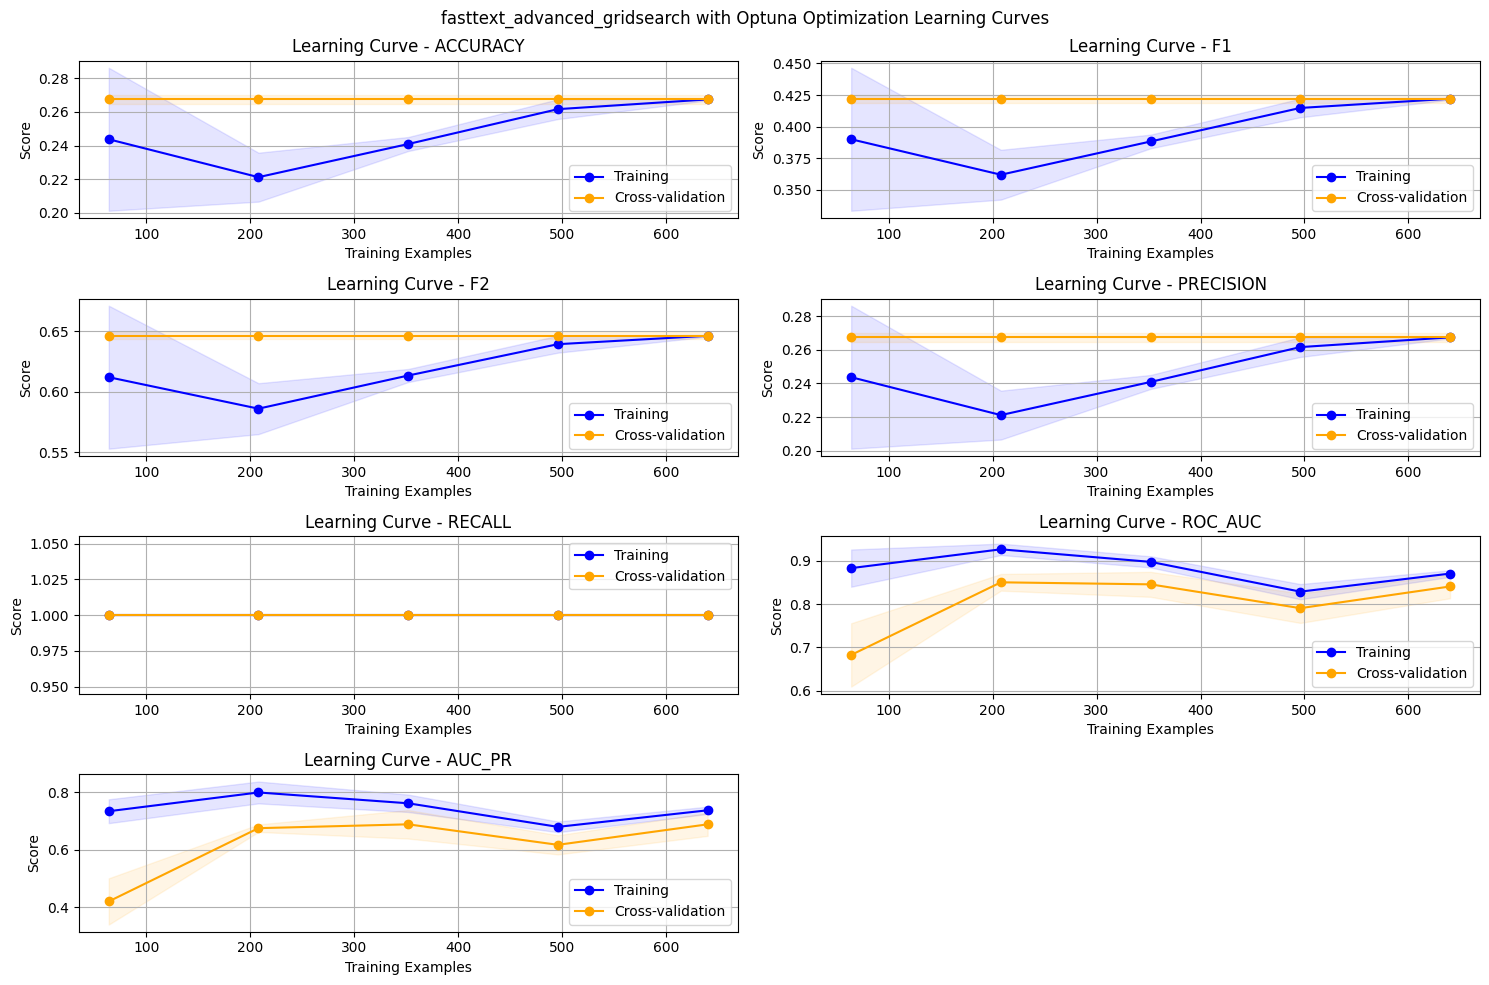


Final Threshold: 0.58
F2-score with default threshold (0.5): 0.659

Test Set Performance:
              precision    recall  f1-score   support

           0       0.98      0.44      0.61       146
           1       0.39      0.98      0.56        54

    accuracy                           0.58       200
   macro avg       0.69      0.71      0.58       200
weighted avg       0.82      0.58      0.59       200

Additional Metrics:
Accuracy   0.585
F2-score   0.755
AUC-ROC    0.883
AUC-PR     0.751



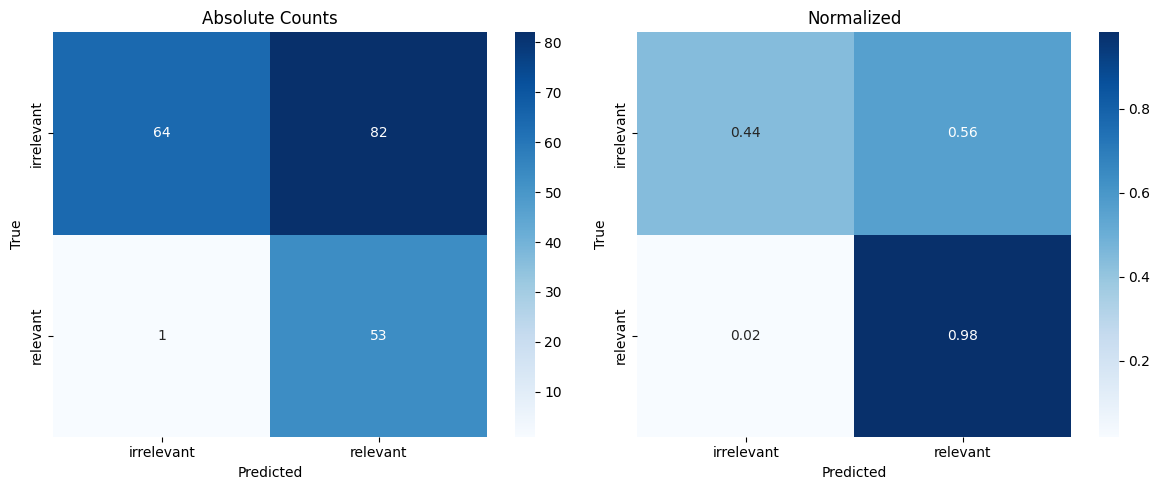

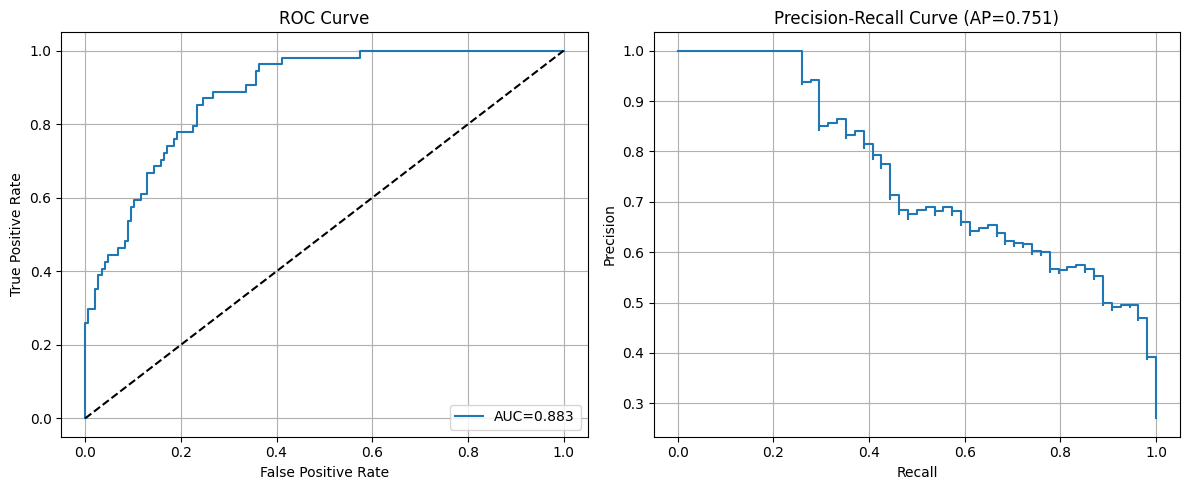


Model saved as model_fasttext_advanced_gridsearch.joblib


In [9]:
#perform train-test split on advanced cleaned data
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

pipeline_fasttext = Pipeline([
    # no more steps, because we use fasttext as end-to-end model here
    ("clf", FastTextSklearnClassifier(
        lr=0.1, 
        dim=100, 
        epoch=5, 
        ws=5,
        wordNgrams=2, 
        minn=2, 
        maxn=4, 
        minCount=2,
        neg=10, 
        thread=1,  # reproducibility
        loss="softmax",
    ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optuna Parameter Space 
print("Starting Optuna hyperparameter optimization ...")

# Define parameter space for Optuna optimization
# GridSearchCV: paper-faithful, compact grid.
param_grid = {
    # Paper sweep for learning rate {0.05, 0.1, 0.25, 0.5}.
    "clf__lr": [0.05, 0.1, 0.25, 0.5],

    # Hidden size ("dim"): h=10 used in paper for sentiment; add 100 as pragmatic option.
    "clf__dim": [10, 100],

    # Paper trains for 5 epochs on sentiment; keep 5, allow 10 as a tiny extension.
    "clf__epoch": [5, 10],

    # Context window; use a stable middle value and a slightly narrower option.
    "clf__ws": [3, 5],

    # Bigrams add 1–4% in the paper; try uni- vs. bi-grams.
    "clf__wordNgrams": [1, 2],

    # Subwords: paper recommends char n-grams; test OFF vs. (3,6).
    "subword_combo": [(0, 0), (3, 6)],

    # Keep vocabulary pruning modest to speed up training.
    "clf__minCount": [1, 5],

    # Keep bucket size reasonable; extremely large buckets can hurt IO/memory.
    "clf__bucket": [2_000_000],

    # Imbalance handling: Set around optimum of first tpe search
    "clf__pos_oversample": [4.5],
}


model_name = "fasttext_advanced_gridsearch"

#grid search
best_model, best_params, study = grid_search_with_optuna(
    estimator=pipeline_fasttext,
    param_grid=param_grid,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    random_state=42,
    model_name=model_name
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10),
    n_jobs=1
)
plt.suptitle(f'{model_name} with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1]

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print(f"F2-score with default threshold (0.5): {quick_f2_score_default_threshold(y_test, y_test_proba):.3f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1]
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': model_name,  # Fixed: remove curly braces
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE/GS + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, f"model_{model_name}.joblib")

print(f"\nModel saved as model_{model_name}.joblib")





